<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="500" height="250" /> 
    
    
#### <font color='navy'> Proyecto. Administración de Riesgos.
    
#### <font color='navy'> Cómite de Inversión y Riesgos.

    
Profesor: Sean Nicolás González Vázquez.

- Luis Fernando Márquez Bañuelos
- Luis Eduardo Jiménez del Muro
- Diego Lozoya Morales

# <font color = "navy"> Estrategia de Inversión  <font color = "black">

El perfil del inversionista es de nivel de riesgo moderado, por lo que ve el riesgo como una oportunidad, mientras sea razonable y justificado por el potencial de la inversión. Además el horizonte de inversión planteado será de 5 años.

Para ello, se plantea la siguiente estructura de portafolio:

- 3 activos ofensivos
- 2 activos defensivos
- Inversión en oro

Donde un activo ofensivo se considera como aquel con un alto potencial de crecimiento, aunque también puede tener una mayor volatilidad. Estos activos suelen estar asociados con sectores en expansión, empresas con ventajas competitivas fuertes o tecnologías disruptivas.

Mientras que los activos defensivos  se caracterizan por su estabilidad y menor sensibilidad a los ciclos económicos. Suelen pertenecer a sectores con demanda constante, como bienes de consumo básico, salud o servicios públicos. Estos activos ofrecen menor volatilidad y suelen mantener un rendimiento estable, incluso en periodos de incertidumbre.

Para mantener un nivel de riesgo aceptable, la estrategia plantea una diversificación de los activos a través de múltiples industrias buscando una correlación baja entre los activos.

# <font color = "navy"> Coyuntura Económica  <font color = "black">

**Resumen de la Coyuntura Económica según BlackRock y J.P. Morgan (2025):**  

Los informes coinciden en que la economía global enfrenta un entorno *transformacional*, marcado por **mega fuerzas** que redefinen inversiones y riesgos. BlackRock destaca la IA, la fragmentación geopolítica y los cambios demográficos como impulsores clave, advirtiendo que *no se trata de un ciclo económico tradicional*, sino de un cambio de paradigma con inflación persistentemente alta (3-4%) y tasas de interés que no retornarán a niveles prepandémicos. J.P. Morgan enfatiza la normalización de políticas monetarias, pero con un enfoque en **inversión acelerada en infraestructura crítica** (IA, energía, seguridad) y el impacto de elecciones globales en políticas proteccionistas y déficits fiscales.  

Ambos subrayan la necesidad de **resiliencia en portafolios**. BlackRock recomienda sobreponderar acciones estadounidenses (especialmente tech y sectores expuestos a IA) y bonos de mercados desarrollados fuera de EE.UU., mientras reduce exposición a bonos gubernamentales a largo plazo. J.P. Morgan propone diversificar con activos reales (infraestructura, oro), ingresos recurrentes (bonos corporativos, dividendos) y mercados emergentes selectos (India, México), alertando sobre valuaciones elevadas en grandes tech y volatilidad por tensiones comerciales.  

En un contexto de **incertidumbre geopolítica y desglobalización**, los papers coinciden en priorizar empresas con poder de fijación de precios, balances sólidos y exposición a innovación. La defensa contra inflación, la adaptación a cadenas de suministro y la atención a políticas disruptivas (ej: aranceles, subsidios) emergen como pilares para navegar un mercado donde *la estabilidad tradicional ha cedido paso a la adaptación constante*.

# <font color = "navy"> Selección de Activos <font color = "black">

## <font color = "royalblue"> Taiwan Semiconductor Manufacturing

### <font color = "dodgerblue"> Descripción de la empresa <font color='black'>

**Taiwan Semiconductor Manufacturing** es la empresa más grande y avanzada en cuanto a la producción de semiconductores en el mundo. Fue fundada en 1987 y su metodología de trabajo no se basa en desarrollar sus propios semiconductores, sino que se centran unicamente en producir los diseños que realizan otras compañías. Han trabajado para más de 500 clientes y manufacturado casí 12 mil productos diferentes con operaciones en Arizona, EE.UU. pero tambien en Taiwan y China.

Se especializan principalmente en los siguientes ramos:

+ Producen chips y procesadores para smartphones y computadoras (incluyendo iPhones de Apple y demás productos).

+ Son el principal productor para los centros de datos y supercomputadoras especializados en la inteligencia artificial, con clientes del calibre de Nvidia y AMD.

+ En el mercado automotriz producen chips encargados de la asistencia al manejo, así como tambien, los equipos de infoentretenimiento que tienen los carros.

No obstante, TSM posee el 73% del market share en la industria de productora de semiconductores, lo que la vuelve líder. Además, dado el modelo de negocio que tienen, únicamente se arriesgan a fallos en su producción, por lo que si estos componentes tienen fallos de diseño no serían atribuibles a TSM, posicionando a la empresa dentro del "Boom" tecnológico y de la inteligencia artificial sin exponerse a tantos riesgos como si los tienen otras empresas como Nvidia.

---

### <font color = "dodgerblue"> Fundamentales <font color='black'>

El margen bruto fue de 54.7%, el operativo de 45% y el neto de un 40% posicionándose casi dos veces por encima del promedio de sus competidores, el cual está en 35%, 25.9% y 22.2% respectivamente. Estos números confirman la fuerza que tiene TSM en la industria en la que compite teniendo unos márgenes altísimos en comparación a sus competidores y crecimientos en sus ingresos.

En los últimos años se ha observado un crecimiento considerable en el FCF de la empresa, lo que muestra la grán capacidad que tienen para realizar nuevas inversiones. Además TSM tiene unos buenos niveles de liquidéz, en el corto plazo con un current ratio de 2.44, mientras que la media de sus competidores está en 2.4. En el largo plazo, cuentan con un solvency de poco más de 2.8, lo que indica, que la liquidez no presenta ningún problema a la empresa.

TSM cuenta con un EPS de 7.04, el cual es aproximadamente 7 veces mayor al de sus competidores, dado que la mayoría ni siquiera sobrepasan el EPS de 1. Su P/BV se encuentra en 6.50 y su P/E en 23.46, mientras que el promedio de la industria está en 4.78 y 22.06 respectivamente, lo que significa que TSM podría estár ligeramente sobrevaluada, pero esto no representa un grave problema dado el dominio y solidez que tienen, y recordando que prácticamente participan en un mercado el cual son dueños por un 73%, por lo que, podemos decir que esta valuada razonablemente.

---

### <font color = "dodgerblue"> Expectativas y planes a futuro <font color='black'>

TSM tiene planes a futuro muy ambiciosos. Anunciaron que planean realizar inversiones en Arizona que llegarían hasta 165 mil millones de dólares, con motivo de abrir tres nuevas plantas de fabricación, dos nuevas instalaciones de empaquetado, un desarrollo e investigación. Planean refinar sus tecnologías de chips 4nm (nanómetros), 3nm, 2nm y CoWoS, que consiste en una tecnología de apilamiento de chips para procedimientos demandantes como la inteligencia artificial. 

Por otro lado, tambien planean invertir en la investigación de nuevos materiales, así como tambien, en una expansión a Europa y Japón, por lo que tendrían producciónes geográficamente más estables. En cuanto al medio ambiente, estan comprometidos con las prácticas de fabricación ecológicas, ahorro de agua, programas de energía renovable y el alcanzar las cero emisiones de carbono.

---

### <font color = "dodgerblue"> Coyuntura Económica <font color='black'>

Ambos BlackRock y JP Morgan sugieren que la industría de inteligencia artificial será de los personajes principales en estos años, por lo que, TCM al ser el líder mundial en la producción de chips, se posiciona como una de las compañías principales para la inversión en empresas tecnológicas. Por otro lado, aunque no es muy grande, tienen diversificación en sus ramas de producción, no solo fabrican chips y semiconductores, sino que están en la producción de autopartes tecnológicas y en la conectividad del internet de las cosas y redes 5G.

A pesar de que en estos tiempos TSM puede sufrir de riesgos por sus operaciones en China y Taiwan, hay que recordar que está planeando una diversificación geográfica en Europa, Japón e inversiones muy grandes en Estados Unidos, lo que puede darles solidez ante estos riesgos. Incluso, debido a sus establecimientos en estos países asíaticos, TSM podría considerarse como una empresa en mercados emergentes, sin embargo, sus fuertes margenes y monopolización del mercado demuestran lo contrario de un activo de mercados emergentes.

## <font color = "royalblue"> Visa <font color = "black">

### <font color = "dodgerblue"> Descripción de la empresa <font color = "black">

**Visa** es una de las principales empresas de tecnología de pagos a nivel global. Fundada en 1958 y con sede en San Francisco, California, Visa opera una de las redes de pagos electrónicos más grandes del mundo, facilitando transacciones entre consumidores, comercios, instituciones financieras y gobiernos en más de 200 países. Su modelo de negocio se basa en la provisión de infraestructura para pagos digitales, permitiendo transacciones rápidas, seguras y eficientes a través de tarjetas de crédito, débito y prepagadas, así como soluciones digitales y de pago sin contacto.  

A diferencia de los bancos emisores, Visa no extiende crédito ni emite tarjetas directamente, sino que actúa como intermediario entre bancos y comercios, obteniendo ingresos principalmente a través de tarifas por transacción y servicios de valor agregado. Su liderazgo en el sector se debe a su red global de aceptación, su capacidad de procesamiento en tiempo real y su enfoque en la innovación, con inversiones en inteligencia artificial, ciberseguridad y tecnologías de pago digital como **Visa Direct** y **tap-to-pay**, que refuerzan su competitividad en un entorno de pagos cada vez más digitalizado.

Su principal mercado se encuentra en Estados Unidos, seguido de China y Alemania, en general cuenta con fuerte presencia tanto en Europa como en Asia, lo cual le permite diversificar sus ingresos alrededor del mundo y exponerse al crecimiento de las economías emergentes donde los pagos digitales son cada vez más comúnes. Dentro de sus principales competidores del sector se encuentran Mastercard, American Express, Discover Financial, entre otros. Una de sus grande ventajas competitivas, además de su infraestructura de pagos, es que es la empresa más grande del sector, convirtiendolo en un negocio tipo monopolio.

---

### <font color = "dodgerblue"> Fundamentales <font color = "black">

La empresa actualmente cuenta con un margen bruto del 77%, un margen operativo del 67.1% y un margen neto del 53.5%. Todos sus márgenes son los más altos de su industria con diferencia, convirtiéndola así en la empresa más eficiente operativamente respacto a sus competidores y las más grande. Tanto su rentabilidad como márgenes son por mucho superiores, por lo que la convierte en una empresa muy sólida y como un buen candidato a inversión a largo plazo dada la salud financiera con la que cuenta.

El Free Cash Flow (FCF) de la empresa ha mantenido un crecimiento constante y considerable, esto es una gran señal de la salud financiera de la empresa, ya que cuentan con bastante excedente que puede ser utilizado para desarrollo de nuevos proyectos, ampliación de infraestructura en nuevos países y pago de dividendo a los inversionistas. Por ello se mantiene Visa como una buena opción de inversión a largo plazo, dada la posición que tiene dentro de su industria y la solidez financiera que ha mostrado a lo argo del tiempo, pues cada vez es más común los pagos con tarjeta en el mundo.

Analizando la liquidez de la empresa, se encuentran bien en el corto plazo con un current ratio de 1.12 siendo superior a la media de la industria **(0.9)**, lo cual indica que puede cubrir sus obligaciones de corto plazo, además de contra con excedentes altos en caso de ser necesarios. En cuanto a su liquidez a largo plazo, se encuentran bastante estables con un solvency ratio de 1.71, por lo que a largo plazo tienen bastante capacidad de cubrir sus obligaciones, mostrando así una fuerte solidez financiera de la empresa tanto en temas operativos como de liquidez.

El EPS de Visa se encuentra en la parte alta de la industria, siendo de 9.79, lo cual indica bastante beneficio ofrecido por la empresa por cada acción que se tiene, esto le da bastante valor a los inverisonistas, así como una buena confianza en la inversión. A pesar de ser líder de su industria y contar con la mejor rentabilidad y márgenes con diferencia, sus múltiplos de valuación se encuentran en un rango razonable. Con un P/BV de 17.93, siendo ligeramente mayor al promedio de la industria **(14.45)** y un P/E de 35.02 frente al promedio de su industria de **(28.25)**, se puede considerar que el mercado valora a Visa con una prima razonable sobre los competidores, pero al ser tan superior en cuestiones financieras y contar con ventas que han crecido considerablemente en los últimos años posiciona a Visa ocmo una buena opción de inversión.

---

### <font color = "dodgerblue"> Planes a futuro <font color = "black">

Visa tiene una estrategia de crecimiento basada en tres pilares clave. Primero, busca profundizar la penetración de sus productos existentes, promoviendo la transición de pagos en efectivo y cheques a pagos digitales, lo que representa una gran oportunidad global. Además, está ampliando su portafolio de servicios de valor agregado, ofreciendo soluciones innovadoras para mejorar la experiencia del cliente y la seguridad de las transacciones. En paralelo, está fortaleciendo su presencia geográfica, especialmente en mercados emergentes, como lo demuestra su adquisición de una participación mayoritaria en Prosa, una empresa mexicana de procesamiento de pagos. Esto busca acelerar la adopción de pagos electrónicos en regiones clave. 

Además, Visa está invirtiendo en tecnologías avanzadas como la inteligencia artificial para mejorar la seguridad y eficiencia de sus operaciones. Con múltiples aplicaciones de IA en uso, la compañía busca optimizar la experiencia del cliente y combatir el fraude. Visa también está comprometida con la sustentabilidad, colaborando con el Cambridge Institute for Sustainability Leadership (CISL) para explorar oportunidades que promuevan un futuro más sostenible utilizando su red global de pagos. Estas estrategias subrayan el compromiso de Visa por mantenerse como líder en la industria de pagos digitales, adaptándose a las necesidades cambiantes de los consumidores y mercados.  

---

### <font color = "dodgerblue"> Coyuntura económica <font color = "black">

En la expectativa económica por parte de BlackRock y J.P. Morgan destacan el aumento de la digitilización, dentro de esta, el incremento de pagos digitales, lo cual es conveniente para Visa ya que es el principal proveedor de este servicio a nivel mundial, sobre todo el incremento de pagos digitales en economías emergentes, lo que incrementa el núemro de cosumidores de Visa. Además es una empresa con ingresos y flujos de efectivo estables, lo cual es conveniente dentro de una situación geopolítica incierta. También busca adaptar la inteligencia artificial para sus servicios y cuestiones de segurifad, estando así expuesta a esta industria con un crecimiento exponencial. Gracias a sus exposición a tendencias de consumo global, adaptación de la inteligencia artificial, diversificación geográfica y fuerte situación financiera, convierte a Visa en una buena oportunidad de inversión debido al desarrollo teconlógico y siendo resistente a movimientos económicos adversos, lo cual se alinea con la estrategia de inversión buscada.

## <font color = "royalblue"> EMCOR Group

### <font color = "dodgerblue"> Descripción de la empresa <font color='black'>

**EMCOR Group** fundado en 1987 con sede en Norwalk, Connecticut en EE.UU. Cuentan con aproximadamente 40 mil empleados y sus principales segmentos de negocio son: 

+ *EMCOR ECS:* servicios de construcción de centrales eléctricas, centros de datos, sistemas de tráfico.
+ *EMCOR EBS:* mantenimiento de instalaciones, plomería, seguridad contra incendios, mejoras en eficiencia energética.
+ *EMCOR EIS:* Mantenimiento de de refinerías petroleras, infraestructura de energía renovable y captura de carbono.

EMCOR es líder en proyectos de infraestructura de EE.UU. beneficiándose de proyectos del gobierno de hasta 1 billón de dólares, para seguridad nacional, clientes comerciales, educación, servicios de salud e incluso para la NASA.

---

### <font color = "dodgerblue"> Fundamentales <font color='black'>

EME obtuvo un margen bruto de 19%, margen operativo de 9.2% y margen neto de 6.9% superando la mediana de sus competidores y estándo un poco por debajo en la media del margen bruto de sus competidores pero superando las de los otros márgenes siendo de 25.3%, 5.5% y 4.9% respectivamente. Además han tendio un crecimiento en sus ingresos los últimos años viéndose como buenos competidores en la industria.

Sus FCF han crecido recientemente obteniendo un 9.2% a comparación de sus la media de sus competidores en 6.1%, lo que indica mayor capacidad de reinvertir capital contra su industria. En cuanto a su liquidez en el corto plazo, tienen un current ratio de 1.30 superando a la media de sus competidores de 1.27, lo cual es bueno. En cuanto al largo plazo, tienen un solvency de aproximadamente 1.6, lo que indica que EME no tiene mucho por lo que preocuparse en su liquidez.

El EPS de EME es de 21.52 superando por mucho a todos sus competidores, lo que indica buena rentabilidad para los inversionistas. Su P/BV de 5.78 está ligeramente por encima de la media de sus competidores de  3.74, sin embargo podría justificarse por los altos rendimientos que presenta en el EPS. Además, su P/E de 17.24 está notablemente por debajo de la media de 26.87 de la industria, lo que quizá podría interpretarse como que EME está ligeramente infravalorada, hacíendola una opción atractiva de inversión.

---

### <font color = "dodgerblue"> Expectativas y planes a futuro <font color='black'>

Gracias al la alta demanda de infraestructura para la computación e inteligencia artificial, EME planea entrar en este mercado expandiéndose aún más en la construcción de centros de datos. Así mismo, planean continuar aprovechándose de proyectos del gobierno estadounidense como nuevas carreteras, redes 5G, energías renovables, conservación del agua y reforzar su expansión en el Reino Unido. Además, este 2025 anunciaron que expandirían su portafolio cerrando un M&A adquiriendo Miller Electric para expandir sus capacidades y alcane geográfico.

---

### <font color = "dodgerblue"> Coyuntura Económica <font color='black'>

Nuevamente, gracias al la fuerza en el mercado que se espera por parte de la inteligencia artificial, EME tiene altas oportunidades de hacerse de grandes proyectos de construcción e infraestructura para centros de datos en los Estados Unidos. Además gracias a sus fuertes alianzas con el gobierno estadounidense, podrían no preocuparse tanto ante tiempos volátiles, sin embargo, tienen que preocuparse por no perder esas alianzas.

Por otro lado, EME tiene poca exposición en otros mercados en el mundo, lo que podría ser complicado adaptarse ante riesgos políticos en EE.UU. Por último, retomando que se esperan tiempos volátiles, podrán estar cubiertos con su amplia segmentación de negocios, impulsándose en las redes eléctricas, e infraestructura para IA y centros de datos.

## <font color='royalblue'> McDonald's Corporation <font color='black'>

### <font color='dodgerblue'> Descripción de la empresa <font color='black'>
**McDonald’s Corp.** es una de las empresas más grandes en el mundo de la comida rápida. Fue fundada oficialmente en 1955 por Raymond Albert Kroc en San Bernardino, California, EE. UU. Actualmente, tiene su sede en Oak Brook, Illinois; sin embargo, opera a nivel nacional e internacional, con presencia en más de 100 países, siendo sus principales mercados Estados Unidos, Alemania, Reino Unido, Francia e Italia.

Principalmente, es reconocida por ser una empresa dedicada a la venta de hamburguesas; no obstante, también vende pollo en distintas presentaciones, al igual que bebidas, papas fritas, entre otros productos. El segmento de Mercados con Licencia de Desarrollo y Corporativo Internacional consiste en mercados con licenciatarios de desarrollo y afiliados dentro del sistema de McDonald’s.

Aunque su giro principal es la venta de alimentos, sus productos son considerados bienes de lujo, ya que la gente suele consumirlos cuando tiene un excedente de dinero. Este comportamiento convierte a McDonald’s en una empresa con un comportamiento cíclico.

---
### <font color='dodgerblue'> Fundamentales <font color='black'>

McDonald’s mostró recientemente un margen bruto del 56.3%, operativo del 45.8% y neto del 31.7%, los cuales se encuentran muy por encima de la media de su industria, que fue del 26.7%, 10.4% y 5.8%, respectivamente. Esto muestra la gran solidez de la empresa frente a sus competidores directos, lo cual es un muy buen indicador.

Su free cash flow se ha mostrado relativamente constante, con un margen actual del 25.7%, un valor sobresaliente respecto a la industria, cuya media se encuentra en 6.2%. Este es un muy buen margen, ya que permite a McDonald’s la oportunidad de reinvertir grandes cantidades, repartir dividendos, etc. Esto resulta atractivo para los inversores, dada su capacidad de crecimiento en el futuro.

Su liquidez no es tan fuerte, ya que cuenta con un current ratio de 1.19 y una solvencia de 0.94. Ambos valores se encuentran por debajo de los niveles deseados; sin embargo, aún logra posicionarse por encima de sus competidores, cuyos ratios medios son de 1.11 y 0.53, respectivamente.

Cuenta con un EPS de 11.39, el mayor de la industria con diferencia, lo que la muestra como la empresa más rentable para los inversionistas. Tiene un P/E de 26.96, el cual es menor a la media de la industria, situada en 48.76. Esto indica una infravaloración respecto a la industria, lo que puede ser un buen indicador con base en el resto de los fundamentales analizados.

---
### <font color='dodgerblue'> Planes a futuro <font color='black'>

A finales de 2024, la empresa compartió que espera alcanzar un total de 50,000 restaurantes en todo el mundo para 2027, lo que significa que tiene pensado abrir alrededor de 10,000 sucursales en los siguientes tres años. Se estima que el 70% de estos nuevos restaurantes estén ubicados en mercados emergentes. Países como China, India, Japón y Brasil son los principales nombres que se mencionan. En caso de lograr materializar esta meta, se estaría hablando del crecimiento más rápido de la empresa en sus casi 70 años de existencia.

---
### <font color='dodgerblue'> Coyuntura económica <font color='black'>

Dada la volatilidad esperada en el mercado estadounidense, McDonald’s es considerado un activo de defensa en la creación del portafolio, ya que es una empresa que muestra una baja reacción frente al mercado, lo que brinda estabilidad. Además, por sus planes a futuro, se espera que se vea beneficiado por el crecimiento de mercados emergentes, lugares en donde planea invertir grandes cantidades de dinero a corto y mediano plazo. Las empresas BlackRock y JPMorgan sugieren inversión en mercados emergentes, lo que se ve bien representado en McDonald’s.

## <font color = "royalblue"> Procter & Gamble <font color = "black">

### <font color = "dodgerblue"> Descripción de la empresa <font color = "black">

**Procter & Gamble (P&G)** es una de las mayores empresas de bienes de consumo del mundo. Fundada en 1837, opera en más de 180 países y cuenta con múltiples de las marcas más grandes del mundo en categorías como cuidado personal, higiene y productos para el hogar. Algunas de sus marcas más reconocidas incluyen Gillette, Pampers, Ariel, Head & Shoulders y Olay.  

Procter & Gamble (P&G) opera bajo un modelo de negocio basado en la producción, comercialización y distribución de bienes de consumo esenciales con una estrategia basada en la innovación, el marketing y la eficiencia operativa. Su enfoque en la construcción de marcas fuertes le permite mantener una alta fidelidad del consumidor y una ventaja competitiva en el sector. A través de una cadena de suministro global optimizada, P&G maximiza su rentabilidad y mantiene costos controlados. Además, su diversificación de productos en distintas categorías y su presencia en múltiples canales de venta, incluyendo retail tradicional y comercio electrónico, le garantizan un flujo de ingresos estable.

Su principal mercado es Estados Unidos, seguido de China y Canadá. Compite con gigantes del sector como Unilever, L'Oréal y Colgate-Palmolive, pero se mantiene como la empresa más grande en términos de ventas y capitalización de mercado. Esta escala y diversificación hacen que P&G sea una compañía sólida y resistente a los ciclos económicos, ya que sus productos son de consumo recurrente y esenciales para los hogares.

---

### <font color = "dodgerblue"> Fundamentales <font color = "black">

La empresa actualmente cuenta con un margen bruto del 51.4%, un margen operativo del 23.3% y un margen neto del 18.4%. Su margen bruto se ubica cercano a la media de su sector **(54.9%)**, y al analizar el margen operativo, este se encuentra por encima de la media del su sector **(21.5%)**, lo cual indica una mayor eficacia operativa en comparación con la competencia. Además su margen neto es el más alto del sector, mostrando así la gran solidez y capacidad financiera de la empresa.

El Free Cash Flow (FCF) de la empresa ha mostrado un crecimiento constante en los últimos años, lo que refleja una sólida salud financiera. Esto indica una operación eficiente, ya que la compañía genera suficiente capital para reinvertir en su crecimiento, distribuir dividendos y explorar otras oportunidades estratégicas. Como resultado, se posiciona como una opción atractiva para los inversionistas, al demostrar estabilidad y capacidad para generar valor a largo plazo.

En cuanto a la liquidez de la empresa se podría decir que a corto plazo existen ciertos problemas, ya que su current ratio es de 0.76, lo cual esta por debajo de la media del sector **(1.04)**, sin embargo, no es tampoco un gran riesgo ya que cuentas con ventas sólidas en crecimiento, márgenes saludables y altos niveles de free cash flow. Estas condiciones le permiten generar suficiente liquidez operativa para cubrir sus obligaciones a corto plazo. En cuanto a liquidez a largo plazo el solvency ratio se ubica por encima de 1.7, lo que nos dice que la empresa en ese aspecto se encuentra bien, por lo que la liquidez a largo plazo no es una preocupación.

El EPS de P&G es el segundo más alto respecto a sus competidores siendo de 6.28, lo cual nos indica bastante rentabilidad y valor generado, sobre todo al comparar contra empresas de su industria, además se ha mantenido constante en los últimos años, mostrando así que es una ganancia por acción sólida a través del tiempo, siendo una buena señal para una inversión a largo plazo. En cuanto a múltiplos de valuación, el P/BV es de 7.82, el cual se encuentra ligeramente encima de la mediana del sector **(5.90)** y el P/E que es de 26.77 se encuentra debajo de la media de la industria **(30.81)**, dado que sus múltiplos están cercanos a la media del sector, y cuenta con los mejores márgenes y rentabilidad sugiere que el mercado podría no estar reconociendo completamente la solidez financiera de la empresa.

---

### <font color = "dodgerblue"> Planes a futuro <font color = "black">

Procter & Gamble (P&G) tiene una estrategia clara de crecimiento basada en cinco pilares: fortalecimiento de sus marcas líderes, mejora continua en la superioridad de productos y distribución, optimización de costos mediante mayor productividad, innovación disruptiva para adaptarse a cambios en el mercado y una estructura organizacional eficiente. Además, la compañía está incrementando su inversión en publicidad y marketing digital, enfocándose en plataformas clave como Douyin en China para fortalecer su presencia en mercados estratégicos. Estas iniciativas buscan consolidar su liderazgo en la industria de bienes de consumo, impulsando tanto el crecimiento de ingresos como la rentabilidad.  

En términos de sostenibilidad y responsabilidad corporativa, P&G ha establecido metas ambiciosas como su plan **"Ambición 2040"**, que busca alcanzar cero emisiones netas de carbono en toda su cadena de suministro. Asimismo, ha reforzado su compromiso con la conservación del agua y la obtención responsable de materiales, respondiendo a las exigencias de los consumidores y accionistas en materia ambiental. Estas iniciativas no solo mitigan riesgos regulatorios y de reputación, sino que también refuerzan la posición de P&G como una empresa bien gestionada y alineada con tendencias de largo plazo, lo que la hace atractiva para inversionistas con un enfoque sostenible.


---

### <font color = "dodgerblue"> Coyuntura económica <font color = "black">

Tanto BlackRock como J.P. Morgan anticpan alta volatilidad en 2025, por lo que incluir una empresa líder en bienes de consumo es importante, ya que es resistente ante presiones inflacionarias y alta volatilidad de mercado. Además tiene buena exposción en mercados emergentes, permitiendo una diversificación de ingresos ante tanta tensión geopolítica a nivel global. Por lo tanto al ser una empresa líder en el mercado, generar ingresos estables y constantes, ayuda a protegerse ante la alta volatilidad, lo cual se alinea con la estrategia de inversión.

## <font color = "royalblue"> Oro <font color = "black">

### <font color = "dodgerblue"> ¿Por qué el oro? <font color = "black">

El oro se ha consolidado como un activo estratégico en 2025, especialmente en un entorno de fragmentación geopolítica. Factores como la reconfiguración de cadenas de suministro, la inversión en infraestructura y cambios demográficos han mantenido la inflación elevada, favoreciendo al oro como resguardo de valor. Además, la creciente competencia entre bloques económicos y las políticas fiscales expansivas han incrementado la volatilidad, lo que refuerza el rol del oro como cobertura ante incertidumbre global. Su comportamiento en eventos recientes, como las elecciones en EE.UU. y Europa en 2024, demuestra su efectividad como refugio en tiempos de inestabilidad.  

Además, el oro ha tomado un papel más relevante en la diversificación de portafolios, cuya correlación negativa con las acciones ha sido inconsistente. Durante periodos de tasas reales bajas o negativas, el oro ha superado en rendimiento a los bonos gubernamentales y ha mostrado una correlación negativa con el S&P 500, estabilizando carteras. La demanda institucional sigue en aumento, con bancos centrales comprando grandes cantidades desde 2022 y países como China elevando sus reservas, lo que refuerza su solidez a largo plazo. Asimismo, los flujos hacia ETFs de oro podrían aumentar con la reducción de tasas en 2025, fortaleciendo aún más su atractivo.  

Finalmente, el oro también se beneficia de una posible depreciación del dólar, ya que sigue siendo una alternativa clave en la diversificación de reservas globales. Si bien enfrenta retos como tasas de interés elevadas y la competencia de criptomonedas, su menor volatilidad y respaldo institucional lo hacen más estable. BlackRock recomienda una asignación de oro dentro de carteras diversificadas, mientras que J.P. Morgan lo sugiere como complemento de activos reales para reforzar la resiliencia. En un escenario de transformaciones estructurales y políticas disruptivas, el oro es es una herramienta clave para proteger y fortalecer inversiones.

---

### <font color = "dodgerblue"> ETF (GLD) <font color = "black">

El **SPDR Gold Shares (GLD)** es uno de los ETFs más grandes y líquidos del mundo para invertir en oro. Lanzado en 2004, GLD está diseñado para replicar el precio del oro físico manteniendo lingotes en bóvedas seguras, lo que permite a los inversionistas exponerse a este activo sin los costos ni las complicaciones de almacenamiento. Con un alto volumen de negociación, GLD proporciona una forma eficiente de acceder al oro con una liquidez superior a la de comprar oro físico directamente.  

Invertir en GLD es una buena estrategia porque permite beneficiarse de la apreciación del oro sin los problemas asociados con su posesión física, como el almacenamiento, el seguro y los costos de transacción elevados. Además, su estructura como ETF lo hace más eficiente en costos en comparación con fondos administrados activamente o con la compra de lingotes. Otro punto clave es su alta liquidez, lo que facilita la entrada y salida de la inversión sin afectar significativamente su precio de mercado. 

En un entorno de alta volatilidad e incertidumbre económica, GLD es una opción sólida para añadir estabilidad y diversificación al portafolio gracias a la correlación baja que tiene frente a las acciones, alineándose con la estrategia de inversión propuesta, ya que logra mitigar riesgos dentro del portafolio y sirve como un "hedge" ante situaciones económicas adversas, lo cual nos otorga un activo de calidad, con potencial de apreciación y una baja volatilidad.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

np.random.seed(42)
plt.rcParams['figure.facecolor'] = 'lightgray'

# <font color = "navy"> Obtención de Datos

In [2]:
tickers = ['TSM', 'EME', 'V', 'PG', 'MCD', 'GLD']

benchmark = 'SPY'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


<font color = "black">

Se eligió como benchmark para el portafolio el S&P 500, ya que todos nuestros activos a excepción del oro cotizan dentro de este índice, por lo que lo vuelve un buen punto de 
referencia.

In [3]:
print(f'Precios de los activos')
display(price.head())
print()

print(f'Volumen de los activos')
display(volume.head())

print(f'Rendimientos diarios de los activos')
display(rt.head())
print()

print(f'Rendimiento y volatilidad de los activos')
pd.set_option('display.float_format', '{:.2%}'.format)
stats_df = pd.DataFrame({
    'Rendimiento Anual': rt.mean() * 252,
    'Volatilidad Anual': rt.std() * np.sqrt(252),
})
stats_df.T

Precios de los activos


Ticker,TSM,EME,V,PG,MCD,GLD
Date,,,,,,
2021-01-04,103.694389,87.781586,211.141418,124.070023,190.810074,182.330002
2021-01-05,104.687706,89.916130,207.990158,124.862206,191.953735,182.869995
2021-01-06,107.324150,97.657501,206.157608,126.176521,191.518036,179.899994
2021-01-07,112.727036,99.467445,207.311493,124.997238,192.407562,179.479996
2021-01-08,110.183411,97.421432,208.901581,124.943199,195.938370,173.339996



Volumen de los activos


Ticker,TSM,EME,V,PG,MCD,GLD
Date,,,,,,
2021-01-04,11262100,253900,10318300,8330900,4055400,14331400
2021-01-05,10583600,293500,6869700,6856400,2576100,12718800
2021-01-06,10609300,432700,7206200,10578000,3083400,18453500
2021-01-07,13556100,195200,10967900,7355400,3142000,7110200
2021-01-08,18976800,199800,6513000,7448500,2639100,24399900


Rendimientos diarios de los activos


Ticker,TSM,EME,V,PG,MCD,GLD
Date,,,,,,
2021-01-05,0.009579,0.024317,-0.014925,0.006385,0.005994,0.002962
2021-01-06,0.025184,0.086095,-0.008811,0.010526,-0.002270,-0.016241
2021-01-07,0.050342,0.018534,0.005597,-0.009346,0.004645,-0.002335
2021-01-08,-0.022564,-0.020570,0.007670,-0.000432,0.018351,-0.034210
2021-01-11,0.032943,-0.010501,-0.011882,-0.006772,-0.007597,-0.001961



Rendimiento y volatilidad de los activos


Ticker,TSM,EME,V,PG,MCD,GLD
Rendimiento Anual,18.84%,39.58%,13.41%,9.45%,12.85%,10.37%
Volatilidad Anual,37.31%,31.07%,22.53%,17.05%,17.07%,14.29%


# <font color = "navy"> Optimización y Evolución de Portafolios

## <font color = "royalblue"> Funciones de Optimización

In [4]:
def portfolio_return(returns, weights):
    return np.dot(returns, weights)

def plot_weights(stocks: list, weights: list | np.ndarray):

    df = pd.DataFrame(weights, index=stocks, columns=['w'])
    filtered_df = df[df['w'] > 0.000001]
    labels = filtered_df.index
    values = filtered_df.iloc[: , 0]

    plt.rcParams['figure.facecolor'] = 'lightgray'
    cmap = plt.get_cmap("Blues")
    custom_colors = cmap(np.linspace(0, 1, len(labels)))
    
    plt.figure(figsize=(8, 8))
    plt.pie(values, labels=labels, autopct='%1.2f%%', startangle=90, colors=custom_colors)
    plt.title("Portfolio Weights")
    plt.show()

def rebalance_stocks(w_original: list, target_weights: list, data: pd.DataFrame, stocks: list, portfolio_value: float) -> pd.DataFrame:

    data = data.sort_index()
    data = data[stocks]
    w_df = pd.DataFrame({
    "Peso Original": w_original,
    "Peso Óptimo": target_weights,
    "Acciones (C/V)" : np.floor((target_weights-w_original) * portfolio_value / data.iloc[-1])
    })
    return w_df.T

def var(returns):
    return np.percentile(returns, 1)

def cvar(returns):
    var = np.percentile(returns, 1)
    return returns[returns < var].mean()

In [5]:
def opt_sharpe(rt: pd.DataFrame, rf: float) -> np.ndarray:
    """
    Optimiza los pesos de un portafolio para maximizar el Sharpe Ratio.

    Parameters
    ----------
    rt : pd.DataFrame
            Rendimientos de los activos.

    rf : float
            Tasa libre de riesgo.

    Returns
    ----------
    np.ndarray

        Pesos óptimos del portafolio.
    """
    mu = (rt.mean() * 252).values
    sigma = rt.cov().values
    n_assets = len(rt.keys())

    # Función para minimizar (-Sharpe Ratio)
    def neg_sharpe_ratio(w, mu, sigma, rf):
        port_return = np.dot(w.T, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
        return -(port_return - rf) / port_vol

    # Restricciones y límites
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1),) * n_assets
    w0 = np.ones(n_assets) / n_assets

    result = minimize(neg_sharpe_ratio, w0, args=(mu, sigma, rf), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [6]:
def lvrr(price: pd.DataFrame, volume: pd.DataFrame, rf: float, pv: int | float) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el Sharpe Ratio ajustado por liquidez.

    Parameters
    ----------
    price : pd.DataFrame
        Precios de los activos.

    volume : pd.DataFrame
        Volumen de los activos.

    rf : float
        Tasa libre de riesgo.

    pv : int | float
        Valor del portafolio.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.
    """
    returns = price.pct_change().dropna()
    mu = returns.mean() * 252
    sigma = returns.cov()
    n_assets = len(returns.keys())

    # Volumen promedio de los últimos 3 meses
    adv = volume.iloc[-90:, :].mean()

    def objective(w):
        H = 1 / (adv * price.iloc[-1])
        lr = np.dot(pv, np.dot(w.T, H))

        port_return = np.dot(w.T, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)

        return -(port_return - rf) / (port_vol * lr)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1),) * n_assets
    w0 = np.ones(n_assets) / n_assets

    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [7]:
def semivariance_montecarlo(rt: pd.DataFrame, rt_benchmark: pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos minimizando la semivarianza.

    Parameters
    ----------
    rt : pd.DataFrame
        Rendimientos de los activos.

    rt_benchmark : pd.DataFrame
        Rendimientos del benchmark.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.
    """
    diff = rt - rt_benchmark.values
    downside = diff.where(diff < 0, 0).std()
    corr = rt.corr()
    S = np.outer(downside, downside) * corr

    weights = np.random.dirichlet(np.ones(len(rt.keys())), size=1_000_000)
    semivariances = np.einsum("ij,jk,ik->i", weights, S, weights) #semivariances = np.array([w.T @ S @ w for w in weights])
    return weights[semivariances.argmin()]

In [8]:
def omega(rt: pd.DataFrame, rt_benchmark: pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el ratio Omega.

    Parameters
    ----------
    rt : pd.DataFrame
        Rendimientos de los activos.

    rt_benchmark : pd.DataFrame
        Rendimientos del benchmark.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.
    """
    diff = rt - rt_benchmark.values
    downside = diff.where(diff < 0, 0).std()
    upside = diff.where(diff > 0, 0).std()

    omega = upside / downside
    n_assets = len(omega)

    def objective(w, omega):
        return -np.dot(w.T, omega)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1),) * n_assets
    w0 = np.ones(n_assets) / n_assets

    result = minimize(objective, w0, args=(omega,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [9]:
def semivariance_cvar_adj(rt: pd.DataFrame, rt_benchmark: pd.DataFrame, target: float) -> np.ndarray:
    """
    Optimiza la asignación de activos minimizando la semivarianza ajustada por CVaR.

    Parameters
    ----------
    rt : pd.DataFrame
        Rendimientos de los activos.

    rt_benchmark : pd.DataFrame
        Rendimientos del benchmark.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.

    float

        Valor de CVaR.
    """

    diff = rt - rt_benchmark.values
    downside = diff.where(diff < 0, 0).std()
    corr = rt.corr()
    S = np.outer(downside, downside) * corr
    n_assets = len(rt.keys())

    def get_cvar(w):
        var = np.percentile(np.dot(rt.values, w), 1)
        return np.abs(np.mean(np.dot(rt.values, w)[np.dot(rt.values, w) < var]))

    # Función para minimizar semivarianza
    def semivariance(w, S):
        return w.T @ S @ w

    # Restricciones y límites
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {"type": "eq", "fun": lambda w: get_cvar(w) - target}
                   )
    bounds = ((0, 1),) * n_assets
    w0 = np.ones(n_assets) / n_assets

    result = minimize(semivariance, w0, args=(S), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, get_cvar(result.x)

## <font color = "royalblue"> Backtest Estático

In [10]:
pd.reset_option('display.float_format')

rf = 0.0010
pv = 1_000_000.0

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_train = benchmark_data.loc[start_date:end_date]
benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()
rt_benchmark_train = benchmark_train.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

### <font color = "dodgerblue"> Máximo Ratio de Sharpe

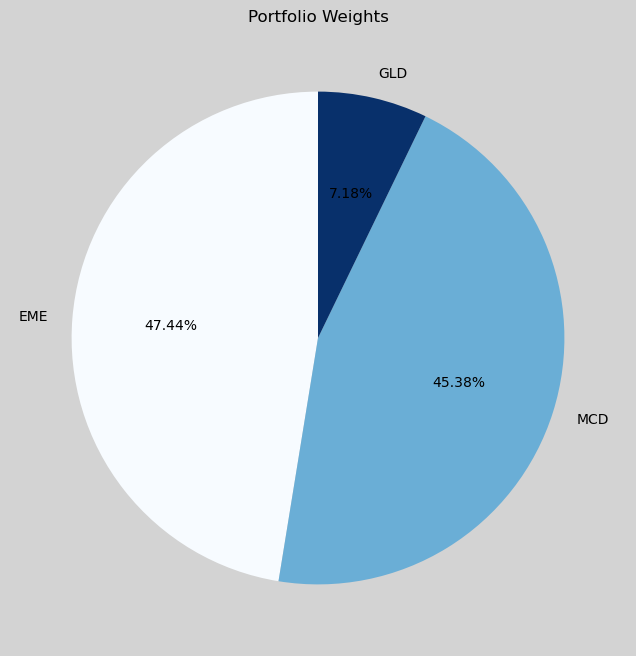

In [11]:
w_sharpe = opt_sharpe(rt_train, rf)
plot_weights(tickers, w_sharpe)

### <font color = "dodgerblue"> Liquidity Variance Return Ratio (LVRR)

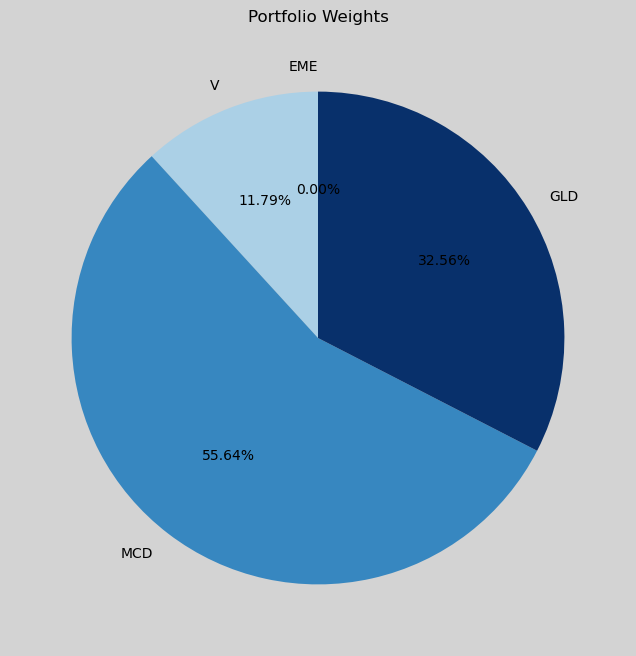

In [12]:
w_lvrr = lvrr(price_train, volume_train, rf, pv)
plot_weights(tickers, w_lvrr)

### <font color = "dodgerblue"> Target Semivariance

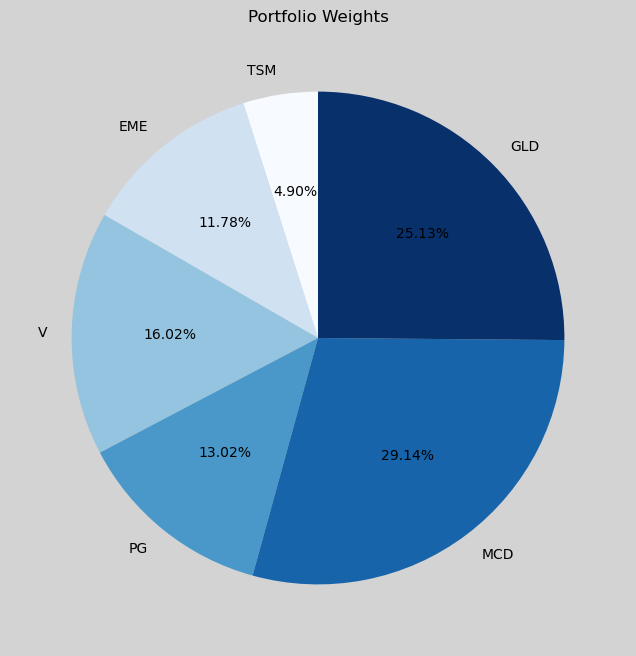

In [13]:
w_semivariance = semivariance_montecarlo(rt_train, rt_benchmark_train)
plot_weights(tickers, w_semivariance)

### <font color = "dodgerblue"> Omega

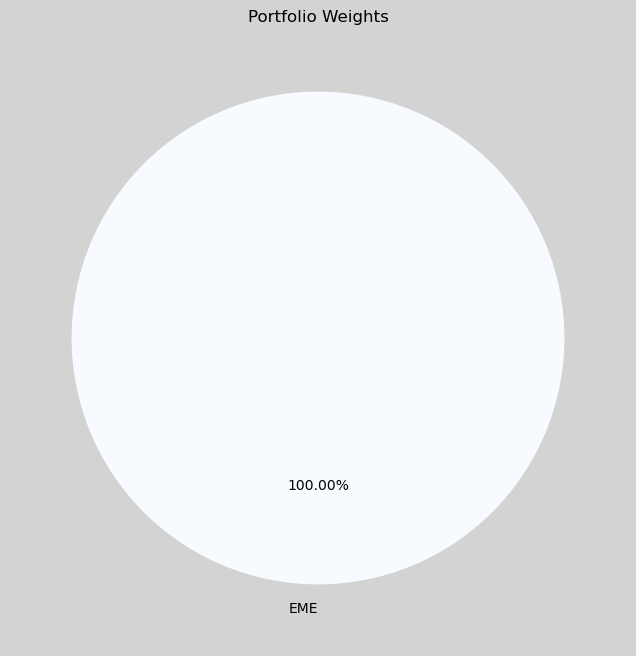

In [14]:
w_omega = omega(rt_train, rt_benchmark_train)
plot_weights(tickers, w_omega)

### <font color = "dodgerblue"> Evolución de los Portafolios

In [15]:
strats = [w_sharpe, w_lvrr, w_semivariance, w_omega]
strats_returns = [portfolio_return(rt_test, w) for w in strats]

# Calcular los retornos acumulados y el dinero acumulado
cumulative_returns = [(1 + r).cumprod() for r in strats_returns]
cumulative_money = [pv * cr for cr in cumulative_returns]

# Crear DataFrame para rendimientos y dinero acumulado
cumulative_returns_df = pd.DataFrame(cumulative_returns, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T
cumulative_money_df = pd.DataFrame(cumulative_money, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T

# Comparar con el benchmark
cumulative_benchmark_returns = (1 + rt_benchmark_test).cumprod().squeeze()
cumulative_returns_df['Benchmark'] = cumulative_benchmark_returns.values
cumulative_money_df['Benchmark'] = pv * cumulative_benchmark_returns.values

# DataFrame con los pesos óptmimos
pd.set_option('display.float_format', '{:.2%}'.format)
df_optimal = pd.DataFrame({
    'Ticker': tickers,
    'Sharpe': w_sharpe,
    'LVRR': w_lvrr,
    'Semivariance': w_semivariance,
    'Omega': w_omega
})
df_optimal.set_index('Ticker', inplace=True)

Pesos óptimos de las estrategias


Ticker,TSM,EME,V,PG,MCD,GLD
Sharpe,0.00%,47.44%,0.00%,0.00%,45.38%,7.18%
LVRR,0.00%,0.00%,11.79%,0.00%,55.64%,32.56%
Semivariance,4.90%,11.78%,16.02%,13.02%,29.14%,25.13%
Omega,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%



Evolución de los rendimientos


,Sharpe,LVRR,Semivariance,Omega
0,-0.009686,-0.008084,-0.007942,-0.010621
1,-0.002638,-0.003937,-0.000813,0.002898
2,-0.001300,-0.005157,-0.002761,0.006252
3,0.007089,0.004352,0.005909,0.006496
4,-0.000713,-0.001505,0.000115,0.001824
...,...,...,...,...
292,0.008168,0.003886,0.005942,0.011647
293,-0.017478,0.000781,-0.009905,-0.045160
294,0.016611,0.020144,0.012385,0.001280
295,-0.024269,-0.011159,-0.013656,-0.037805



Evolución del valor del portafolio


,Sharpe,LVRR,Semivariance,Omega,Benchmark
0,9.903142e+05,9.919156e+05,9.920580e+05,9.893788e+05,9.918333e+05
1,9.877015e+05,9.880109e+05,9.912515e+05,9.922456e+05,9.886384e+05
2,9.864172e+05,9.829158e+05,9.885144e+05,9.984491e+05,9.899926e+05
3,9.934103e+05,9.871934e+05,9.943560e+05,1.004935e+06,1.004126e+06
4,9.927018e+05,9.857081e+05,9.944705e+05,1.006768e+06,1.002602e+06
...,...,...,...,...,...
292,1.452757e+06,1.213974e+06,1.358045e+06,1.851086e+06,1.249422e+06
293,1.427365e+06,1.214921e+06,1.344593e+06,1.767490e+06,1.227243e+06
294,1.451075e+06,1.239395e+06,1.361247e+06,1.769753e+06,1.234121e+06
295,1.415860e+06,1.225564e+06,1.342657e+06,1.702848e+06,1.201250e+06


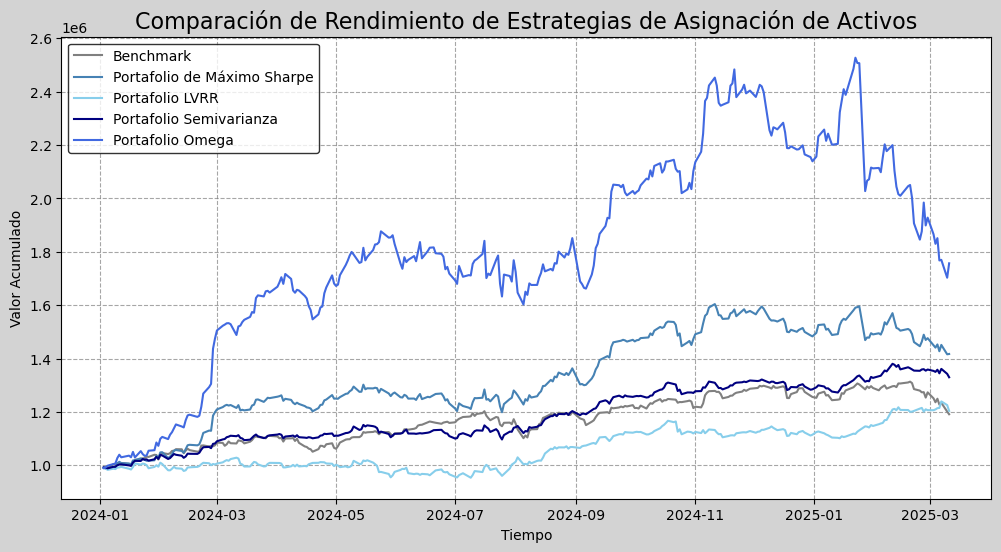

El valor final del portafolio Sharpe es de 1,417,082.67
El valor final del portafolio LVRR es de 1,203,743.38
El valor final del portafolio Semivariance es de 1,329,813.94
El valor final del portafolio Omega es de 1,756,786.88
El valor final del portafolio Benchmark es de 1,191,264.05


In [16]:
print(f'Pesos óptimos de las estrategias')
display(df_optimal.T)
print()

pd.reset_option('display.float_format')
print(f'Evolución de los rendimientos')
display(pd.DataFrame(strats_returns, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T)
print()

print(f'Evolución del valor del portafolio')
display(cumulative_money_df)

plt.figure(figsize=(12, 6))

plt.plot(rt_test.index, cumulative_money_df['Benchmark'], label='Benchmark', c = 'gray')
plt.plot(rt_test.index, cumulative_money_df['Sharpe'], label='Portafolio de Máximo Sharpe', c = 'steelblue')
plt.plot(rt_test.index, cumulative_money_df['LVRR'], label='Portafolio LVRR', c = 'skyblue')
plt.plot(rt_test.index, cumulative_money_df['Semivariance'], label='Portafolio Semivarianza', c = 'navy')
plt.plot(rt_test.index, cumulative_money_df['Omega'], label='Portafolio Omega', c = 'royalblue')

plt.title('Comparación de Rendimiento de Estrategias de Asignación de Activos', fontsize=16)
plt.xlabel('Tiempo')
plt.ylabel('Valor Acumulado')

plt.legend(frameon=True, facecolor='white', edgecolor='black', loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.show()

for i in cumulative_money_df.columns:
    print(f'El valor final del portafolio {i} es de {cumulative_money_df[i].iloc[-1]:,.2f}')

# <font color = "navy"> Métricas de Desempeño

In [17]:
rf = 0.0480

X = rt_benchmark_test['SPY'].values.reshape(-1, 1)
y = [strats_returns[i] for i in range(len(strats_returns))]
betas = np.array([LinearRegression().fit(X, i).coef_[0] for i in y])

# Cálculo de rendimiento anualizado, volatilidad y Sharpe
port_ret = np.mean(strats_returns, axis=1) * 252
port_vol = np.std(strats_returns, axis=1) * np.sqrt(252)
sharpe = (port_ret - rf) / port_vol

# Cálculo de alpha
alpha = port_ret - (rf + betas * (((rt_benchmark_test.mean()).iloc[0] * 252)-rf))

# Cálculo de el ratio Sortino
down_risk = [np.minimum(i, 0).std() * np.sqrt(252) for i in strats_returns]
sortino = (port_ret - rf) / down_risk

summary = pd.DataFrame({
    'Rendimiento Anual': port_ret,
    'Volatilidad Anual': port_vol,
    'Sharpe Ratio': sharpe,
    'Beta': betas,
    'Alpha': alpha,
    'Sortino Ratio': sortino
})
summary.set_index(pd.Index(['Sharpe', 'LVRR', 'Semivariance', 'Omega']), inplace=True)
summary

,Rendimiento Anual,Volatilidad Anual,Sharpe Ratio,Beta,Alpha,Sortino Ratio
Sharpe,0.314969,0.194236,1.374452,0.885331,0.170339,2.136407
LVRR,0.165133,0.124378,0.941749,0.333794,0.080701,1.552523
Semivariance,0.247611,0.106207,1.879458,0.525137,0.142295,3.217892
Omega,0.551422,0.375329,1.341283,1.525178,0.336957,1.930255


<font color = "black">

El portafolio que optimiza el Sharpe obtuvo altos rendimientos con una volatilidad mayor a la que soporta el inversionista. Tiene un ratio de Sharpe de 1.37 y un ratio de Sortino de 2.13, valores bastantes buenos. Además, obtuvo una beta de 0.88, lo que significa que tiene una relación similar al mercado, sin embargo, su alpha es de 0.17, indicando que logró generar rendimientos superiores a los esperados.

El portafolio LVRR tiene una rendimiento esperado muy bajo y una volatilidad moderada. Obtuvo un ratio de Sharpe de 0.94 y un ratio de sortino de 1.55, ambos son malos indicadores. Su beta es de 0.33, representando un bajo seguimiento del mercado. Tiene un Alpha de 0.08, indicando que sus rendimientos generados fueron bastantes similares a los esperados.

El portafolio que optimiza la semivarianza muestra un rendimiento considerable con una volatilidad muy baja. Su ratio de Sharpe es de 1.87 y su sortino es de 3.21, indicadores de que es una muy buena opción de inversión. Además, cuenta con una beta de 0.52, lo que significa que tiene una reacción menor a la del mercado y un alpha de 0.14, o sea que se obtuvieron mejores rendimientos a los esperados.

El portafolio Omega tiene un rendimiento muy alto, acompañado de una volatilidad muy alta, tanto que no es recomendable para nuestro inversionista. Muestra un ratio de sharpe de 1.34 y un sortino de 1.93, lo que muestra una buena relación rendimiento-volatilidad. Su beta de 1.52, mostrando una sobrereacción contra el mercado y un alpha de 0.33, indicando un rendimiento obtenido mayor al esperado.

Dado el perfil del inversionista y las métricas obtenidas, el portafolio que se le recomienda al inversionista es el de semivarianza, pues es el que más se alinea con el objetivo de inversión, debido a sus buenos retornos manteniendo un nivel de riesgo bajo.

# <font color = "navy"> Mejor Portafolio (Semivarianza)

<font color = "black">

Recordando la estrategia de inversión inicial y el perfil del inversionista, queremos un portafolio con un nivel de riesgo moderado, por lo que, elegir un portafolio de muy alto rendimiento pero alto riesgo no sería una opción. Por lo tanto, decidimos elegir el portafolio que optimiza la semivarianza.

Este portafolio tiene un 24.76% de rendimiento y 10.62% de volatilidad, por lo que es un grán rendimiento para el riesgo tan bajo que ofrece. Además los pesos obtenidos están bien distribuidos en todos los activos, por lo que, estamos obteniendo la exposición a activos ofensivos y defensivos que queríamos.

Además, lo anterior se relaciona con lo comentado en la coyuntura económica. El paper de BlackRock menciona la alza que habrá en la volatilidad en estos tiempos, entonces el método de optimización de semivarianza nos ayuda en esto, dado que estamos minimizando la volatilidad negativa de nuestro portafilio, protegiéndonos y obteniendo una volatilidad mas acorde al perfil del inversionista.

Por otro lado, se menciona la importancia que tendran las megafuerzas, por lo que, la exposición que estamos teniendo en inteligencia artificial, infraestructura eléctrica e ifraestructura datacenters, nos ayuda aprovecharnos de estos cambios en la economía.

Para finalizar, mencionar que hay presión inflacionaria, y ante ello, tenemos activos que nos protegan en caso de que la inflación suba, como el oro y acciones de empresas seguras que se espera que les vaya bien en estos periodos como Procter & Gamble y McDonalds.

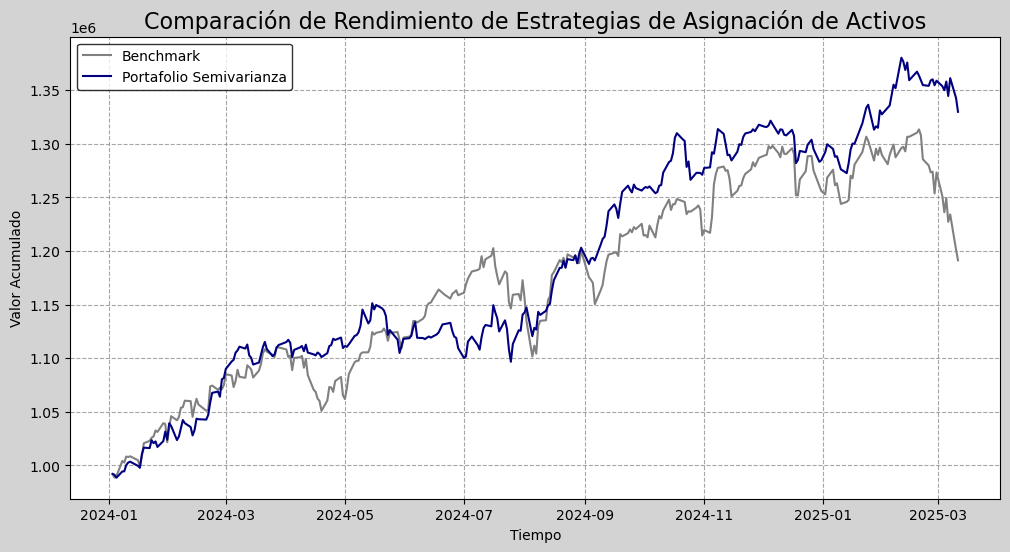

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(rt_test.index, cumulative_money_df['Benchmark'], label='Benchmark', c = 'gray')
plt.plot(rt_test.index, cumulative_money_df['Semivariance'], label='Portafolio Semivarianza', c = 'navy')

plt.title('Comparación de Rendimiento de Estrategias de Asignación de Activos', fontsize=16)
plt.xlabel('Tiempo')
plt.ylabel('Valor Acumulado')

plt.legend(frameon=True, facecolor='white', edgecolor='black', loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.show()

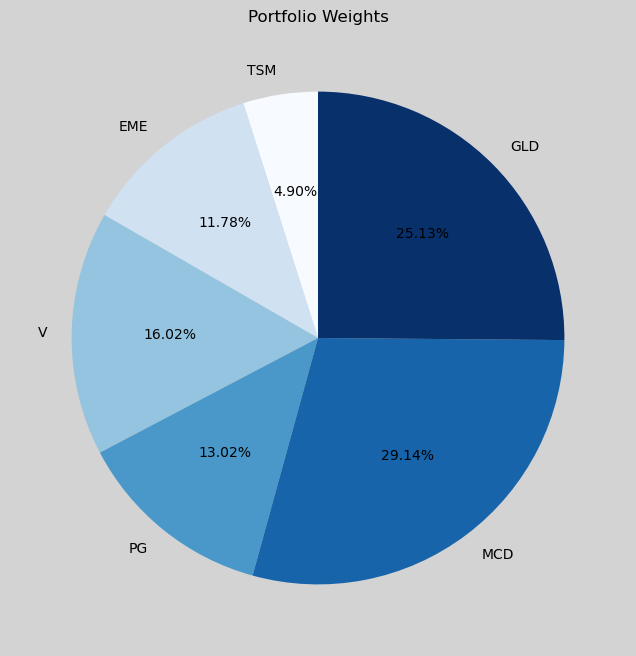

In [19]:
plot_weights(tickers, w_semivariance)

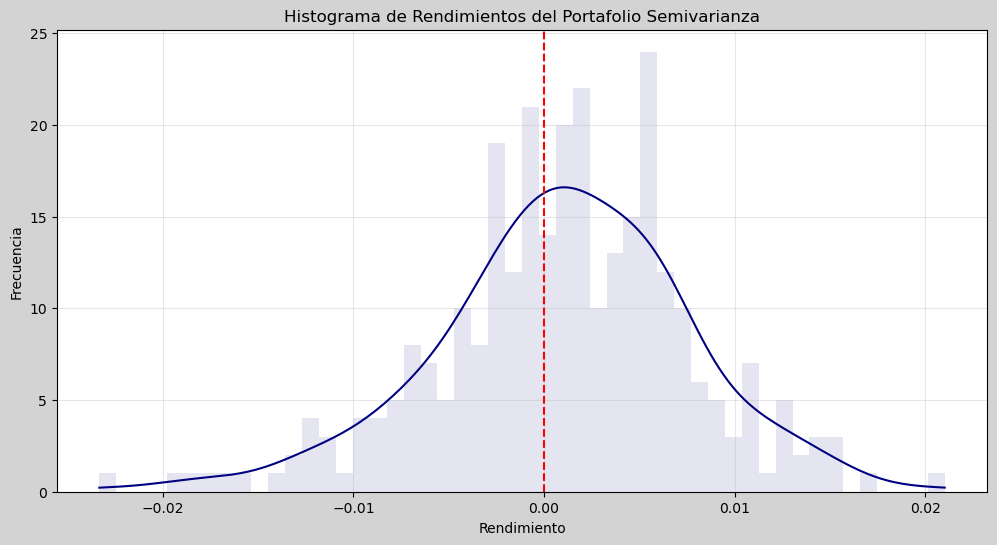

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(strats_returns[2], color='navy', alpha=0.1, kde=True, bins=50, edgecolor=None)
plt.title('Histograma de Rendimientos del Portafolio Semivarianza')
plt.xlabel('Rendimiento')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='red', linestyle='--', label='Cero')
plt.grid(alpha=0.3)
plt.show()

<font color = "black">

Gracias a este histograma podemos ver que la distribución de los rendimientos del portafolio está sesgada, indicando que tenemos mayor cantidad de rendimientos positivos que negativos, por lo que, concluimos que la optimización de semivarianza tuvo buenos resultados, y en efecto, minimizó el downside risk.

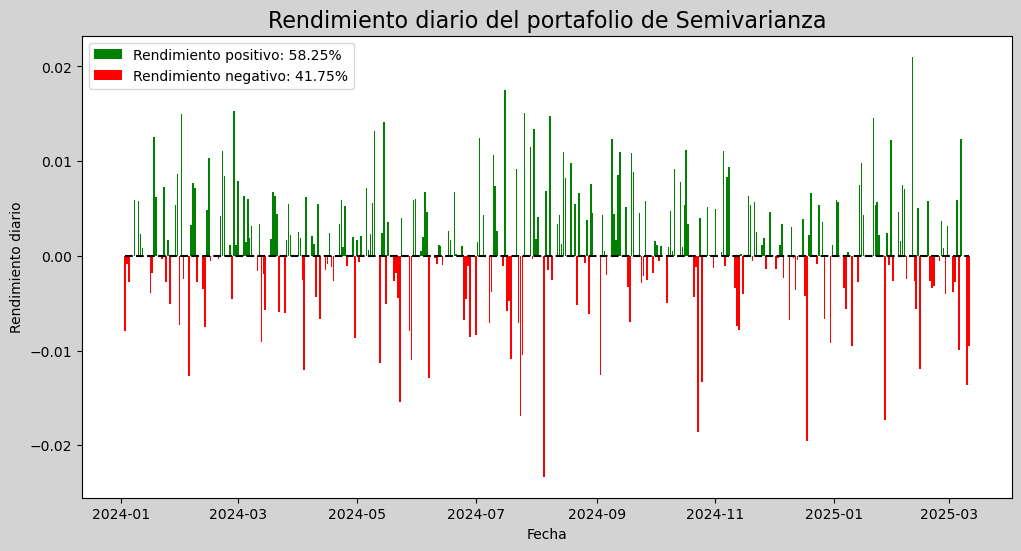

In [21]:
rets = pd.Series(strats_returns[2], index=rt_test.index)

positive = len(strats_returns[2][strats_returns[2] > 0])
negative = len(strats_returns[2][strats_returns[2] < 0])
positive_percentage = positive / (positive + negative)
negative_percentage = negative / (positive + negative)

plt.figure(figsize=(12, 6))
plt.bar(rets.index[rets > 0], rets[rets > 0], color='green', label=f'Rendimiento positivo: {positive_percentage:.2%}')
plt.bar(rets.index[rets < 0], rets[rets < 0], color='red', label=f'Rendimiento negativo: {negative_percentage:.2%}')
plt.title('Rendimiento diario del portafolio de Semivarianza', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Rendimiento diario')
plt.hlines(0, rets.index[0], rets.index[-1], colors='black', linestyles='dashed')
plt.legend()
plt.show()

<font color = "black">

La proporción de rendimientos positivos del portafolio es de 58.25% y la de los rendimientos negativos del 41.75%. Observamos que el mayor rendimiento obtenido en un día fue del 2%, mientras que el mínimo de -2.33%.

# <font color = "navy"> Riesgo

## <font color = "royalblue"> VaR

In [22]:
print(f'El VaR con 99% de confianza a un día del portafolio de Semivarianza es de {var(strats_returns[2]):.2%}')

El VaR con 99% de confianza a un día del portafolio de Semivarianza es de -1.74%


<font color = "black">

El valor de nuestro portafolio crece de una forma relativamente constante, con ciertas caídas pronunciadas, pero en pocas ocasiones. En su mayoría tiende a crecer, este comportamiento explica como el VaR del portafolio es tan bajo, ya que es de solo 1.74%, esto también por la volatilidad tan baja que tuvo el portafolio la cual es de solo 10.62% anual.

## <font color = "royalblue"> ES

In [23]:
print(f'El ES con 99% de confianza a un día del portafolio de Semivarianza es de {cvar(strats_returns[2]):.2%}')

El ES con 99% de confianza a un día del portafolio de Semivarianza es de -2.05%


<font color = "black">

El ES obtenido de igual forma que el VaR es bastante bajo siendo de solo 2.05%, al ser ligeramente mayor al VaR, significa que las pérdidas extremas más grandes del VaR no son tan grandes, esto igual ocasionado por la baja volatilidad lograda a través del portafolio.

## <font color = "royalblue"> Tiempo de Liquidación del Portafolio

In [24]:
money_positions = w_semivariance * pv
buy_prices = price.loc['2024-01-02']
n_shares = np.floor(money_positions / buy_prices)
adv = volume.iloc[-90:, :].mean()
n_days = np.ceil(n_shares / adv)
pd.DataFrame(n_days).T

Ticker,TSM,EME,V,PG,MCD,GLD
0,1.0,1.0,1.0,1.0,1.0,1.0


<font color = "black">

Según el volumen promedio de los útlimos 3 meses, liquidar mi posición tardaría un día en cada activo, lo que implica que si deseas liquidar el portafolio completo tardarías un día. Esto se debe a la alta liquidez de nuestros activos dentro del mercado estadounidense, por lo que el riesgo de liquidez es bastante bajo.

## <font color = "royalblue"> Estrategia de Mitigación de Riesgo

<font color = "black">

Primero calculamos el VaR del portafolio en dinero para ver su valor.

In [25]:
var_money = (cumulative_money_df['Semivariance'].iloc[-1] * var(strats_returns[2]))
print(f'El VaR en dinero con 99% de confianza a un día del portafolio de Semivarianza es de ${-var_money:,.2f}')

El VaR en dinero con 99% de confianza a un día del portafolio de Semivarianza es de $23,185.46


<font color = "black">

Como ya se mostró, el VaR de nuestro portafolio es de 1.74% que en dinero sería $\$23,185.46$ dado el valor final del portafolio en el periodo del test. El VaR y ES obtenidos son bastante bajos lo cual es buena señal del portafolio seleccionado de acuerdo al perfil de nuestro inversionista. Sin embargo, pueden existir momentos de mayor volatilidad donde el VaR del portafolio podría subir a niveles más alto de los que soporta el nivel de riesgo del inversionista.

Para ello se propone realizar un rebalanceo del portafolio con un target C-VaR. Se busca realizar este rebalanceo basados en el C-VaR del portafolio por la consistencia de los resultados dentro de la optimización. Un problema que representa realizar este rebalanceo, es que al mover los pesos de cada activo para cumplir con nuestro C-VaR objetivo nos desviamos mucho de la estrategia de inversión inicial que es invertir en el portafolio de mínima semivarianza.

Para solucionar este problema y mantener nuestra estrategia de inversión recurrimos a reliazar una nueva optimización de portafolio, donde buscamos el portafolio de mínima semivarianza utilizando como restricción C-VaR, de esta forma mantenemos la estrategia del portafolio sin sobrepasar el nivel de C-VaR establecido.

El C-VaR del portafolio fue de 2.05%, para realizar el ajuste tomamos como target un 2% de C-VaR.

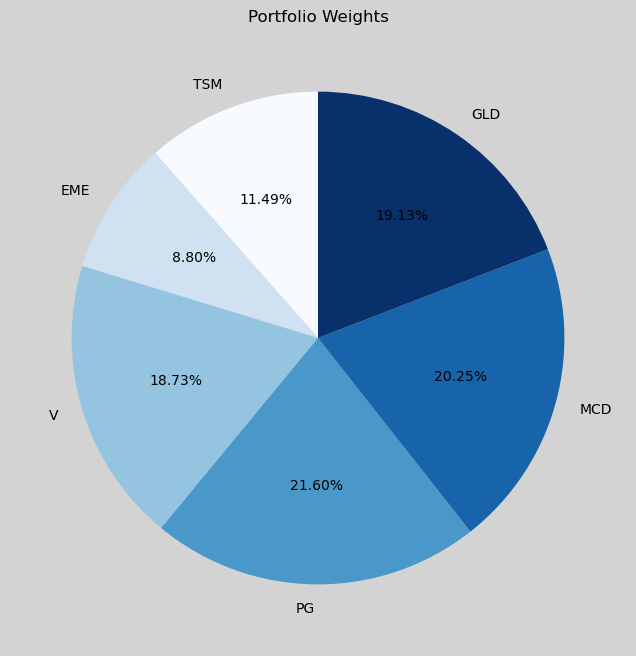

El CVaR del portafolio de Semivarianza ajustado por CVaR es de 2.00%


In [26]:
# Target Semivariance adjusted by C-VaR
weights, cvar_pct = semivariance_cvar_adj(rt_test, rt_benchmark_test, target = 0.02)
plot_weights(tickers, weights)
print(f'El CVaR del portafolio de Semivarianza ajustado por CVaR es de {cvar_pct:.2%}')

In [27]:
rebalance_stocks(w_semivariance, weights, price_test, tickers, cumulative_money_df['Semivariance'].iloc[-1])

Ticker,TSM,EME,V,PG,MCD,GLD
Peso Original,0.049028,0.117814,0.160179,0.130220,0.291418,0.251341
Peso Óptimo,0.114900,0.087950,0.187325,0.215996,0.202500,0.191329
Acciones (C/V),514.000000,-107.000000,108.000000,658.000000,-386.000000,-297.000000


<font color = "black">

Una vez realizado el rebalanceo llegamos a lo siguiente:

- **Comprar** 514 acciones de `TSM`, 108 acciones de `V` y 658 acciones de `PG`.
- **Vender** 107 acciones de `EME`, 386 acciones de `MCD` y 297 acciones de `GLD`.

## <font color = "royalblue"> Matriz de Correlación

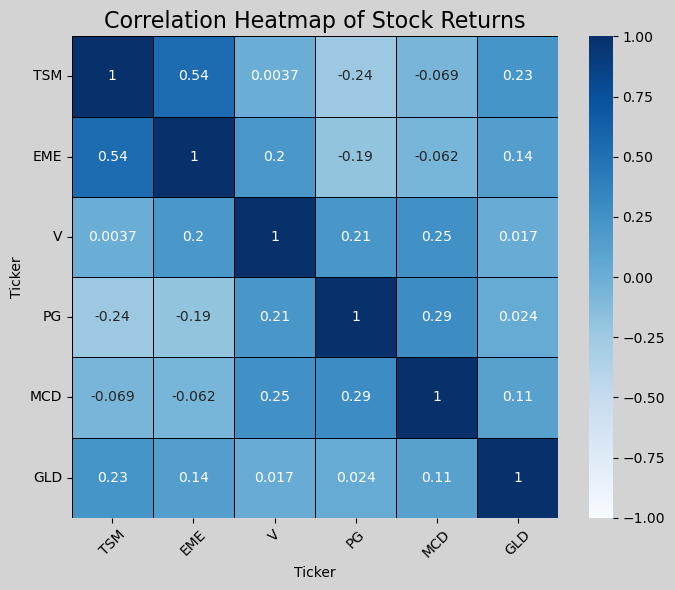

In [28]:
corr = rt_test.corr()
plt.figure(figsize=(7, 6))
sns.heatmap(corr, 
            annot=True, 
            cmap='Blues', 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5, 
            linecolor='black')

plt.title('Correlation Heatmap of Stock Returns', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<font color='black'>

Para evaluar el riesgo entre los activos de un portafolio, es fundamental analizar la correlación entre ellos. En este caso, la matriz de correlación revela que, en general, las relaciones entre los activos son bajas o moderadas. La correlación más alta se observa entre EMCOR y Taiwan Semiconductor Manufacturing (0.54). Este comportamiento tiene sentido, ya que en ambos casos se trata de empresas que comparten similitudes sectoriales: las primeras pertenecen al sector de bienes de consumo discrecional y básico, mientras que las segundas se ven influenciadas por el ciclo económico, lo cual afecta su demanda en función del crecimiento o recesión.

En contraste, la correlación más baja se da entre Taiwan Semiconductor Manufacturing y Procter & Gamble (-0.24), lo que puede explicarse por la diferencia en los sectores a los que pertenecen. PG, al formar parte del sector de bienes de consumo básico, mantiene una demanda relativamente estable sin importar las condiciones económicas. Además, muchos activos muestran correlaciones cercanas a cero, lo que indica una débil relación entre ellos.

En conjunto, la baja correlación entre los activos sugiere una buena diversificación del portafolio. Cabe señalar que la selección de activos se basó principalmente en las perspectivas económicas publicadas por BlackRock y JP Morgan, lo cual refuerza el enfoque estratégico de esta construcción.

## <font color = "royalblue"> Investigación de Riesgos

### <font color = "dodgerblue"> Taiwan Semiconductor Manufacturing (TSM) <font color = 'black'>

TSM es de las acciones mas arriesgadas en nuestro portafolio, se encuentra en una posición delicada debido a las crecientes tensiones políticas y comerciales entre Estados Unidos y China. Analizando la distribución de los ingresos de TSM, observamos que el 68.8% depende de EE.UU., el 11.5% depende de China y un 9.3% de Taiwan, lo que significa que TSM está  obligada a cumplir estrictamente con las regulaciones y políticas comerciales estadounidenses, porque sino, estarían arriesgando más de la mitad de sus ingresos. 

La ubicación de TSM en Taiwán la hace susceptible a las tensiones entre China y Taiwán. Cualquier aumento en el conflicto podría detener o interrumpir las operaciones de TSM, afectando su capacidad de producción y suministro a clientes globales.  Para mitigar estos riesgos, TSM ha iniciado la diversificación y tienen planteado invertir en la construcción de nuevas plantas e instalaciones en Japón, Arizona (EE.UU.) y Alemania, lo que podría ayudar a mejorar sus relaciones con EE.UU.

TSM tambien enfrenta riesgos en su cadena de suministro debido a su alta concentración en Taiwán, y no muy alta eficiencia en los suministros. Además, están en dónde ha habido fuertes desastres naturales últimamente, por ejemplo, el día 21 de este año, sufrieron un terremoto que les generó pérdidas de aproximadamente 165.63 millones de dólares. Por otro lado, TSM requiere infraestructura eléctrica muy grande, así como tambien, un consumo enorme de agua, lo ha hecho que tengan planes de diversificar sus operaciones.

### <font color = "dodgerblue"> Visa <font color='black'>

En el ámbito político, Estados Unidos enfrenta un escenario de proteccionismo comercial bajo la administración de Donald Trump, quien ha amenazado con imponer aranceles del 25% a exportaciones de socios clave como México y China, lo que podría alterar las cadenas de suministro globales y reducir el flujo transfronterizo de transacciones, impactando a empresas como Visa . Además, la revisión del T-MEC en 2026 genera incertidumbre sobre la integración económica en América del Norte, afectando la confianza de inversionistas y empresas . A esto se suman políticas migratorias restrictivas, como reformas a visas y green cards, que podrían disminuir las remesas, un segmento crítico para economías emergentes y para servicios financieros internacionales . Paralelamente, regulaciones climáticas como el Mecanismo de Ajuste Fronterizo de Carbono imponen costos adicionales a sectores vinculados al comercio global, presionando márgenes operativos .  

En el plano económico, la volatilidad cambiaria y la inflación persistente en mercados emergentes erosionan el poder adquisitivo, reduciendo el volumen de transacciones procesadas por actores globales como Visa . En Estados Unidos, el crecimiento proyectado del 2.7% en 2025 contrasta con un déficit fiscal récord (6.4% del PIB en 2024) y una deuda pública que supera el 121% del PIB, lo que podría limitar la capacidad de estímulo económico y generar presiones inflacionarias recurrentes . A nivel global, la desaceleración en Europa con un crecimiento anémico del 1.7% en la eurozona y las tensiones comerciales entre Estados Unidos y China (40% del PIB mundial) aumentan el riesgo de una crisis económica global.

Visa enfrenta desafíos operativos vinculados a ciberataques y fallas tecnológicas, que podrían comprometer su infraestructura de pagos digitales y afectar la confianza de usuarios y socios comerciales. Además, la dependencia de sistemas de terceros (bancos, procesadores y redes de telecomunicaciones) en mercados emergentes, como América Latina o Asia, expone a la empresa a interrupciones por inestabilidad local o estándares regulatorios divergentes. También enfrenta riesgos de cumplimiento regulatorio, especialmente ante normativas antilavado de dinero (AML) y protecciones al consumidor en múltiples jurisdicciones, que exigen inversiones constantes en adaptación tecnológica y legal. Finalmente, la creciente competencia de fintechs y sistemas de pago locales (como Pix en Brasil o UPI en India) amenaza su cuota de mercado, obligándola a innovar bajo presión en un sector altamente dinámico.

### <font color='dodgerblue'> EMCOR <font color='black'>

EMCOR Group enfrenta amenazas derivadas del proteccionismo comercial, como posibles aranceles que encarecerían insumos y complicarían sus cadenas de suministro. Además, regulaciones ambientales y de seguridad laboral incrementan los costos operativos, mientras que la inestabilidad geopolítica en regiones como Latinoamérica o Ucrania pone en riesgo proyectos internacionales, particularmente en energía, que representa el 9% de sus ingresos. Su alta dependencia de contratos gubernamentales también lo expone a cambios en políticas públicas o recortes presupuestarios, como posibles ajustes en la Ley de Infraestructura de EE.UU., que afectarían su cartera actual.

A nivel interno, la empresa enfrenta presión en márgenes por la competencia con firmas como Fluor y por la exposición cíclica al sector construcción, que genera el 63% de sus ingresos. También ha sido blanco de ciberataques, lo que evidencia vulnerabilidades digitales. La integración de adquisiciones como Miller Electric plantea desafíos organizacionales, mientras que su dependencia de subcontratistas y las disrupciones en la cadena de suministro han elevado los costos SG&A en un 9.8% durante 2024. Todo esto exige una gestión ágil, fortalecimiento digital y mayor resiliencia operativa.

### <font color='dodgerblue'> McDonald's <font color='black'>

En el ámbito político, McDonald’s enfrenta riesgos como tensiones geopolíticas, regulaciones laborales y presión climática. Sabotajes en Medio Oriente afectaron el 10% de sus ingresos, mientras que la implementación de salarios mínimos más altos en EE.UU. aumentó sus costos laborales en 742 millones de dólares. Además, su expansión en mercados emergentes como India enfrenta obstáculos por la volatilidad cambiaria y la competencia local, lo que en 2023 redujo sus ingresos en 921 millones de dólares. Las políticas ambientales también representan un reto, especialmente en regiones como la UE, donde se exigen empaques 100% reciclables en 2030.

En cuanto a riesgos operativos, el modelo de franquicias de McDonald’s, con un 93% de restaurantes operados por terceros, complica el control de calidad y la gestión uniforme. La cadena de suministro global también es vulnerable, como lo evidenciaron los brotes de E. coli en 2024, que obligaron a implementar auditorías más estrictas. Asimismo, la empresa se expone a posibles fallos logísticos y laborales, como huelgas o desabastecimientos, que podrían afectar operaciones clave. Estos desafíos requieren una gestión ágil para preservar la reputación y estabilidad operativa de la marca.

### <font color = "dodgerblue"> Procter & Gamble <font color='black'>

En el ámbito político, P&G enfrenta amenazas como posibles aranceles comerciales entre EE.UU. y México, que podrían elevar sus costos operativos al afectar el 10% de sus envíos marítimos a EE.UU. Además, tensiones geopolíticas (como la reducción de su dependencia de China del 45% al 28% en manufactura) exigen inversiones en diversificación de cadenas de suministro en países como México e India. A esto se suma la presión regulatoria ambiental, como exigencias de transparencia en el abastecimiento de pulpa de bosques boreales en Canadá, lo que podría generar costos adicionales si no se alinean con estándares globales de sostenibilidad.  

P&G enfrenta desafíos operativos vinculados a su cadena de suministro global, como la dependencia de mercados emergentes (China, India, Brasil), que, si bien impulsan crecimiento, son vulnerables a inestabilidades políticas, cambios regulatorios ambientales o interrupciones logísticas. Además, ha sido criticada por el uso de químicos potencialmente dañinos (benceno, PFAS) en productos de cuidado personal y por prácticas laborales cuestionables en su cadena de aceite de palma, lo que podría generar retiros de productos, sanciones o daño a la confianza del consumidor. Aunque ha diversificado su manufactura (reduciendo exposición en China e invirtiendo en México e India), persisten riesgos de disrupciones por tensiones geopolíticas o crisis en regiones clave. Además como se mencionó previamente en la investigación de los activos, la liquidez a corto plazo es relativamente baja lo que puede ocasionar problemas de solvencia sumado a ciertos posibles aumentos en sus costos.

### <font color = "dodgerblue"> Oro (GLD) <font color='black'>

El oro enfrenta presión a la baja si las tasas de interés suben o se mantienen elevadas, sin embargo, recordando lo que se menciona en los papers de BlackRock y JPMorgan, se espera que las tasas de interés bajen, lo que le daría mayor atractividad al oro. Sin embargo, en el caso de las tasas suban, el oro enfrentaría riesgos ya que pierde atractivo frente a activos que generan como bonos en un entorno de mayor rentabilidad libre de riesgo.

# <font color = "navy"> Conclusión

<font color='black'>

Los activos elegidos para el proyecto fueron TSM, Visa, EMCOR, McDonald's, Procter & Gamble y el Oro, los cuales cumplen una función para la estrucutra del portafolio llegando a un equlibrio entre activos con alto potencial de crecimiento pero volátiles y activos sólidos y más seguros. Para elegir los activos se buscaron empresas con fundamentales fuertes que demuestren la solidez financiera de estas empresas, además de no tener valuaciones excesivamente caras. También se agrego el oro como un hedge contra posibles incrementos de inflación. Uno de los enfoques principales a través del portafolio, dado el perfil del inversionista, fue una fuerte diversificación a través de distintas industrias para poder mitigar el riesgo buscando una correlación baja entre activos. Por último se buscó que los activos estuvieran en sintonía con la expectativa económica establecida por J.P. Morgan y BlackRock para aprovechar las áreas de oportunidad de crecimiento.

La estrategia la cual utilizamos para invertir fue el portafolio de **Target Semivariance**, ya que en concepto va de acuerdo a un inversionista de riesgo moderado, ya que buscas minimizar tu riesgo a la baja. También en comparación con las otras estrategias fue muy superior en su relación riesgo-rendimiento, teniendo los ratios de sharpe y sortino más altos. Además de ener un alpha positivo, lo cual indica que esperas rendimientos por encima del mercado, todo esto contando con una beta de mercado y volatilidad bajas.

Por parte de los riesgos cuantitativos, contamos con un VaR de 1.74% y un C-VaR de 2.05%, los cuales son bastante bajos, ya que son las posibles máximas pérdidas a un día con un 99% de confianza. En caso de presentar volatilidad más alta el portafolio y sobrepasar un nivel de VaR y C-VaR con el cual este comodo el perfil de inversionista desarrollamos un proceso de rebalanceo con un portafolio de **Target Semivariance adjusted by C-VaR**, donde optimizamos la semivarianza del portafolio cumpliendo con un C-VaR objetivo según el perfil del inversionista.

Por otro lado, en el riesgo cualitativo uno de los principales factores que afectaría a todos los activos del portafolio son las políticas de Trump relacionadas a los aranceles, pues esto podría provocar incrementos en la inflación, lo cual puede tener cierto impacto en el portafolio por el desaceleramiento del consumo. Además es posible que empresas como Procter & Gamble y EMCOR tengan aumentos en sus costos operativos y TSM al estar en Taiwán importar sus productos por parte de empresas estadounidenses como Nvidia sería más caro. 

En los riesgos operacionales uno de los principales es el de TSM donde por las tensiones entre Taiwán y China lo cual podría afectar su producción y cadenas de suministros. Para Visa uno de los principales problemas pueden ser las distintas regulaciones en diferentes países respecto a protección de consumidores y lavado de dinero, donde tendría que ajustar sus operaciones según lo requerido en cada país. La apuesta de EMCOR en inversión de energías renovables se ve afcetada por la política de Trump que no apoya en gran medida a las energías limpias, siendo que EMCOR tiene múltiples contratos gubernamentales. McDonald's se encuentra expuesto a fallos logísticos y un mal control de calidad por el gran tamaño de sus operaciones y el gran número de restaurantes operados por terceros. Por último Procter & Gamble presenta retos operativos en sus cadenas de suministros a nivel global ya que depende en cierta medida de mercados emergentes que pueden llegar a tener inestabilidad además de la manufactura afectada por tensiones geopolíticas y aranceles.

En conclusión se cuenta con un portafolio bien diversificado con un nivel de riesgo relativamente bajo, que en el periodo de prueba tuvo muy buenos resultados, conformado por activos con una alta solidez financiera y que se acomodan a la expectativa económica. Si bien, cuentan con riesgos debido a las tensiones geopolíticas y decisiones de Donald Trump, no representan riesgos muy graves para las empresas y para ello se cuenta con una buena diversificación, ya que no todas se verían afectadas por las mismas razones. Con esto se logra un buen portafolio alineado al perfil de inversionista con riesgo moderado, pues hay potencial de ganancias sin asumir grandes riesgos.

# <font color = "navy"> Referencias Bibliográficas <font color='black'>

> Naidu, R. (2024, 7 noviembre). Unilever y Procter & Gamble enfrentan riesgos por amenaza de Trump de imponer aranceles a México. Yahoo Finance. https://es-us.finanzas.yahoo.com/noticias/unilever-procter-gamble-enfrentan-riesgos-133916488.html

> dcfmodeling.com. (s. f.). El procter & Gamble Company (PG): Análisis PESTLE [enero-2025 Actualizado]. DCF, SWOT, CANVAS, PESTEL, BCG Editable Templates. https://dcfmodeling.com/es/products/pg-pestel-analysis

> Shalit, A. (2024, 19 diciembre). Procter & Gamble Commits to Enhanced Disclosures Regarding Sourcing from Boreal Forests in Canada -. Green Century. https://www.greencentury.com/procter-gamble-commits-to-enhanced-disclosures-regarding-sourcing-from-boreal-forests-in-canada/

> Digest, G. (s. f.). Evaluating a company’s impact (the case of Procter & Gamble). Green Digest. https://www.greendigest.co/p/evaluating-a-company-s-impact-the-case-of-procter-gamble

> Visa adquirirá participación mayoritaria en Prosa para acelerar la adopción de pagos digitales en México. (s. f.). Visa. https://www.visa.com.mx/acerca-de-visa/sala-de-noticias/notas-de-prensa/-visa-adquirira-participacion-mayoritaria-en-prosa-para-acelerar.html

> Lo que hacemos | Liberar oportunidades para todos. (s. f.). Visa. https://www.visa.com.mx/acerca-de-visa.html

> Goel, S., & Webb, E. (2025, 27 febrero). Marc Benioff throws shade at Microsoft and Big Tech’s massive AI spending. Business Insider. https://www.businessinsider.com/marc-benioff-salesforce-microsoft-big-tech-ai-spending-2025-2

> América Retail. (2024, marzo 27). Construyendo marcas: La estrategia impactante de P&G. https://america-retail.com/secciones/marketing/construyendo-marcas-la-estrategia-impactante-de-pg/

> M, T. M. (2025, 13 marzo). Trump, tecnología y tipos de interés: la "triple T" que ya sacude la economía global en este 2025. elconfidencial.com. https://www.elconfidencial.com/economia/2025-03-13/economia-global-perspectivas-2025-inversiones-bra_4084421/

> Bloomberg Línea. (2024, 5 de febrero). Ventas de McDonald’s se debilitan y los ingresos no cumplen las estimaciones. Recuperado de https://www.bloomberglinea.com/2024/02/05/ventas-de-mcdonalds-se-debilitan-y-los-ingresos-no-cumplen-las-estimaciones/

> Business Wire. (2025, 26 de febrero). EMCOR Group, Inc. Reports Fourth Quarter and Full Year 2024 Results. Recuperado de https://www.businesswire.com/news/home/20250226342943/en/EMCOR-Group-Inc.-Reports-Fourth-Quarter-and-Full-Year-2024-Results

> EMCOR Group. (s.f.). Safety, Quality & Productivity. Recuperado de https://emcorgroup.com/about-us/safety-quality-productivity

> Investing.com. (2024, 26 de febrero). Análisis DAFO de McDonald’s: perspectivas de las acciones ante desafíos y oportunidades globales. Recuperado de https://es.investing.com/news/swot-analysis/analisis-dafo-de-mcdonalds-perspectivas-de-las-acciones-ante-desafios-y-oportunidades-globales-93CH-3078849

> McDonald’s. (s.f.). Commitment to Quality. Recuperado de https://www.mcdonalds.com/us/es-us/about-our-food/our-food-philosophy/commitment-to-quality.html

> Street Insider. (2025). Form 10-K EMCOR Group, Inc. For: Dec 31. Recuperado de https://www.streetinsider.com/SEC+Filings/Form+10-K+EMCOR+Group%252C+Inc.+For%253A+Dec+31/24404919.html

> Yahoo! Finance. (2024, 4 de marzo). EMCOR stock’s 15% YTD decline raises questions. Recuperado de https://finance.yahoo.com/news/emcor-stocks-15-ytd-decline-170800120.html

> Estrategias de Inversión. (2023, 6 de diciembre). McDonald’s planea una expansión global récord para 2027. Recuperado de https://www.estrategiasdeinversion.com/actualidad/noticias/bolsa-eeuu/mcdonalds-planea-una-expansion-global-record-para-n-670129

> Feed. (2025, March 3). TSMC to invest $100 billion in the US – What’s driving this massive move and how will it reshape the chip. The Economic Times. https://economictimes.indiatimes.com/news/international/us/tsmc-100-billion-us-investment-chip-manufacturing/articleshow/118689588.cms?from=mdr

> Team, C. (2024, October 2). Growth strategy and future Prospects of Taiwan semiconductor manufacturing Company. CANVAS, SWOT, PESTEL & BCG Matrix Editable Templates for Startups. https://canvasbusinessmodel.com/blogs/growth-strategy/taiwan-semiconductor-manufacturing-company-growth-strategy?srsltid=AfmBOorQt3GrGKerp5L92rY9Dff2Za-GUBZDtrxgG8tvJUZi2ZXvSa8Y

> Slijkerman, J. F. (2025, March 10). TSMC pledges $100bn in US investment as governments push for semiconductor influence. ING Think. https://think.ing.com/articles/governments-seek-greater-influence-over-semiconductor-sector/

> 2025 global semiconductor industry outlook. (2025, February 20). Deloitte Insights. https://www2.deloitte.com/us/en/insights/industry/technology/technology-media-telecom-outlooks/semiconductor-industry-outlook.html

> Company, T. S. M. (2025, March 3). News article structure. Taiwan Semiconductor Manufacturing Company Limited. https://pr.tsmc.com/english/news/3210

> Tsmc. (n.d.). TSMC Arizona - Taiwan Semiconductor Manufacturing Company Limited. https://www.tsmc.com/static/abouttsmcaz/index.htm

> Lin, A. (2025, March 17). TSMC risks and disadvantages in Taiwan - Andy Lin's Long-term Stock Investment Blog. Andy Lin’s Long-term Stock Investment Blog. https://www.granitefirm.com/blog/us/2025/03/16/risks-and-disadvantages/?utm_source=chatgpt.com

> Staff, F. (2024, November 27). TSMC caught in crossfire of US-China tech war, struggling to maintain neutrality. Firstpost. https://www.firstpost.com/tech/tsmc-caught-in-crossfire-of-us-china-tech-war-struggling-to-maintain-neutrality-13839248.html?utm_source=chatgpt.com

> Vision, M. (2024, September 25). Taiwan Semiconductor Manufacturing Company Limited (TSM)’s geopolitical risks could weigh on shares. Ainvest. https://www.ainvest.com/news/taiwan-semiconductor-manufacturing-company-limited-tsm-s-geopolitical-risks-could-weigh-on-shares-240910102a23ed5593dace7f/?utm_source=chatgpt.com

> Zacks. (n.d.). Zacks Industry Outlook EMCOR, MasTec, Dycom Industries, Primoris Services and Orion Group. Nasdaq. https://www.nasdaq.com/articles/zacks-industry-outlook-emcor-mastec-dycom-industries-primoris-services-and-orion-group

> Tolbert, F. (2025, February 26). EMCOR’s Surprising Stock Surge: Defying Expectations with Strategic Growth. Kondor EXP. https://smartphonemagazine.nl/en/2025/02/26/emcors-surprising-stock-surge-defying-expectations-with-strategic-growth/

> AnalystConsensusTarget. (2025, April 2). Acquisition of Miller Electric will expand presence in data centers and manufacturing. Simply Wall St. https://simplywall.st/community/narratives/us/capital-goods/nyse-eme/emcor-group/acquisition-of-miller-electric-will-expand-presence-in-data-centers-and-manufacturing

> EMCOR Group, Inc. | Mechanical & Electrical Construction, Energy & Facilities Services, Sustainability & Green Building Solutions. (n.d.). https://emcorgroup.com/

> FactSet Research Systems Inc. (s.f.). FactSet [Base de datos]. https://www.factset.com

> BlackRock Investment Institute. (2024). 2025 Global Outlook: Building the transformation. BlackRock.

> J.P. Morgan Private Bank. (2024). 2025 Outlook: Building on strength. J.P. Morgan.


# <font color = "navy"> Anexos <font color='black'>

## <font color = "royalblue"> Fundamentales

In [29]:
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]

    return bs, ist, cf

Múltiplos de TSM


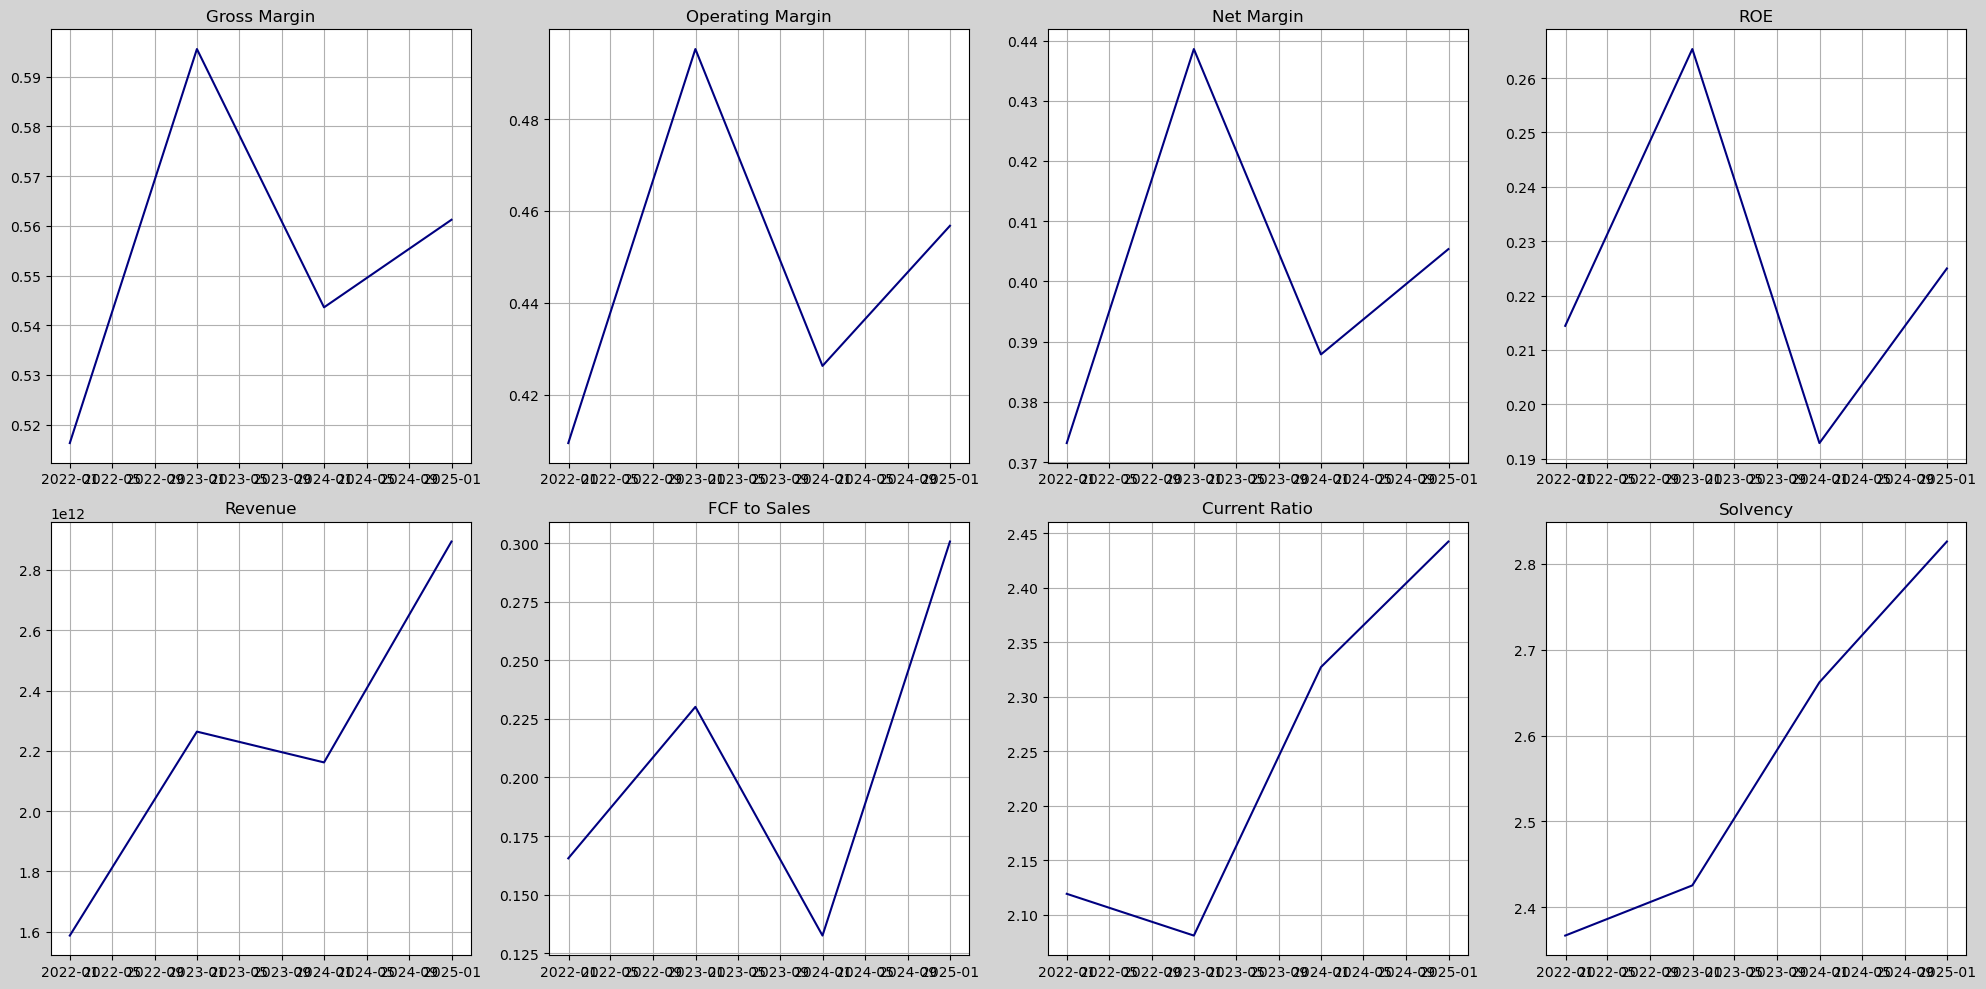

Múltiplos de EME


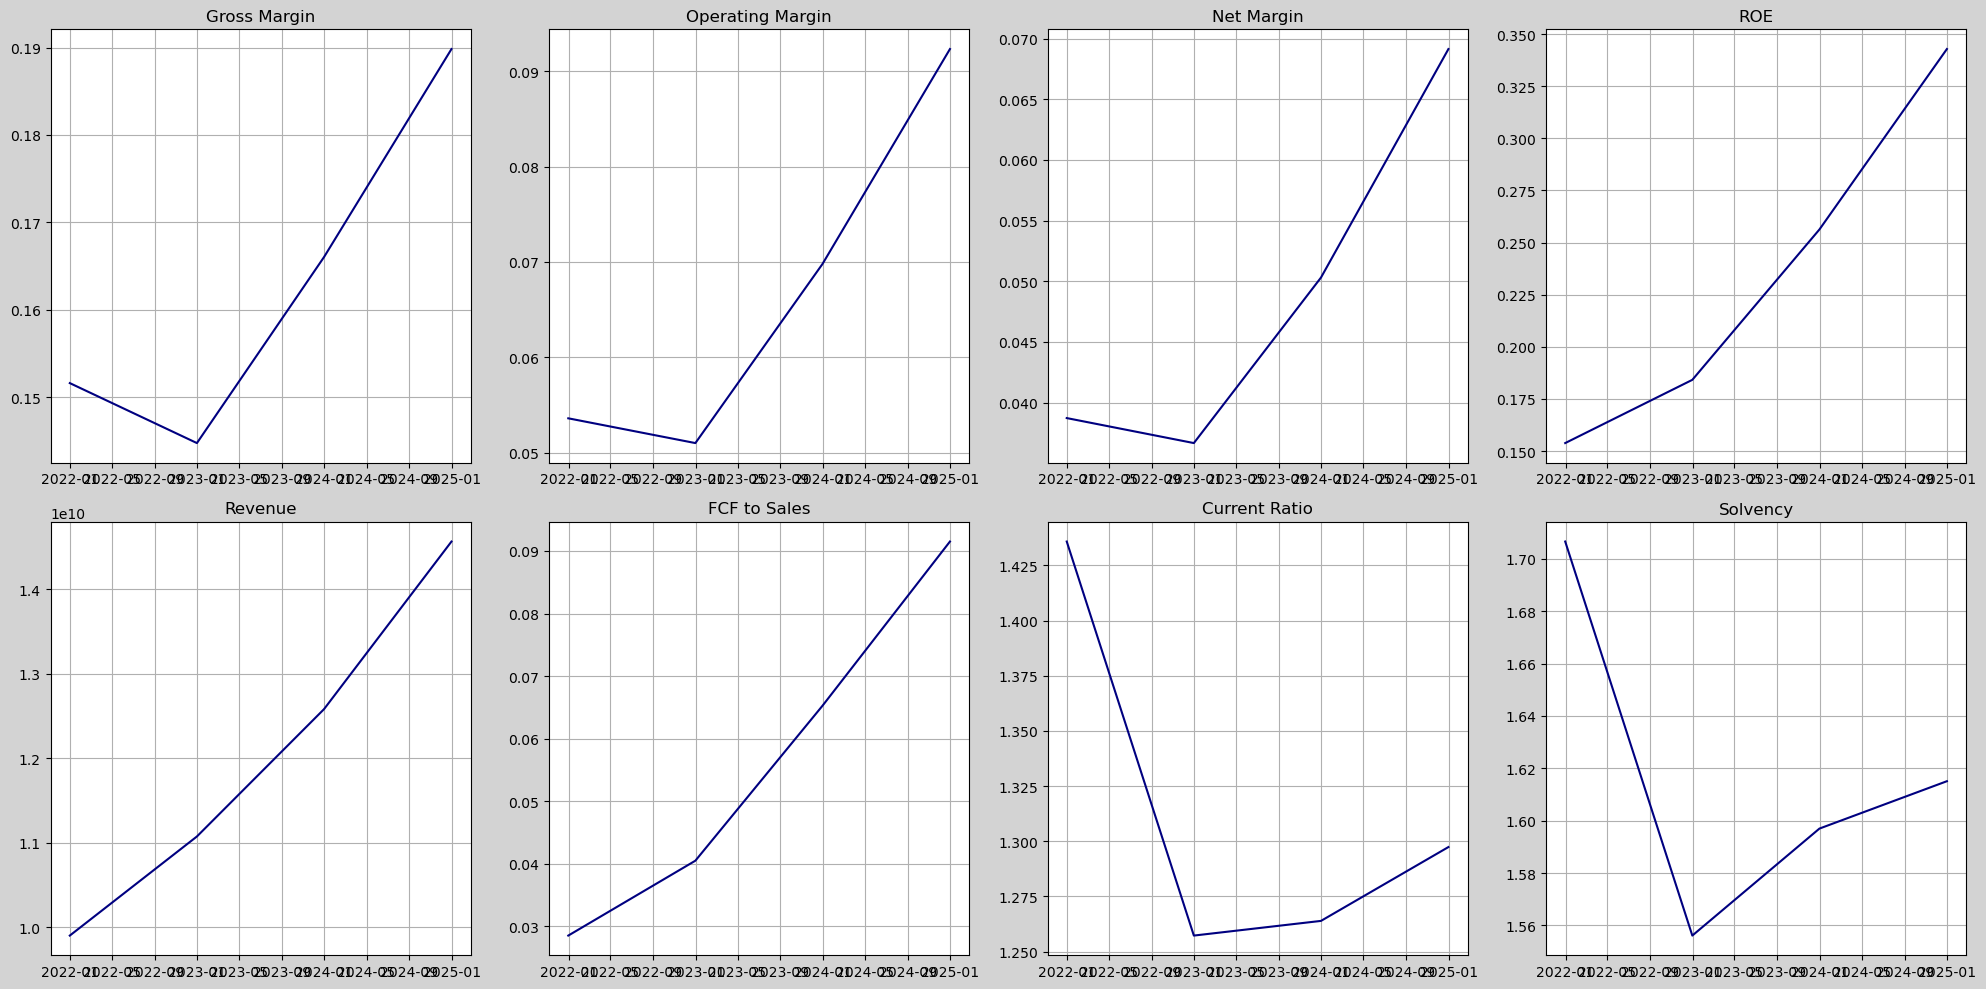

Múltiplos de V


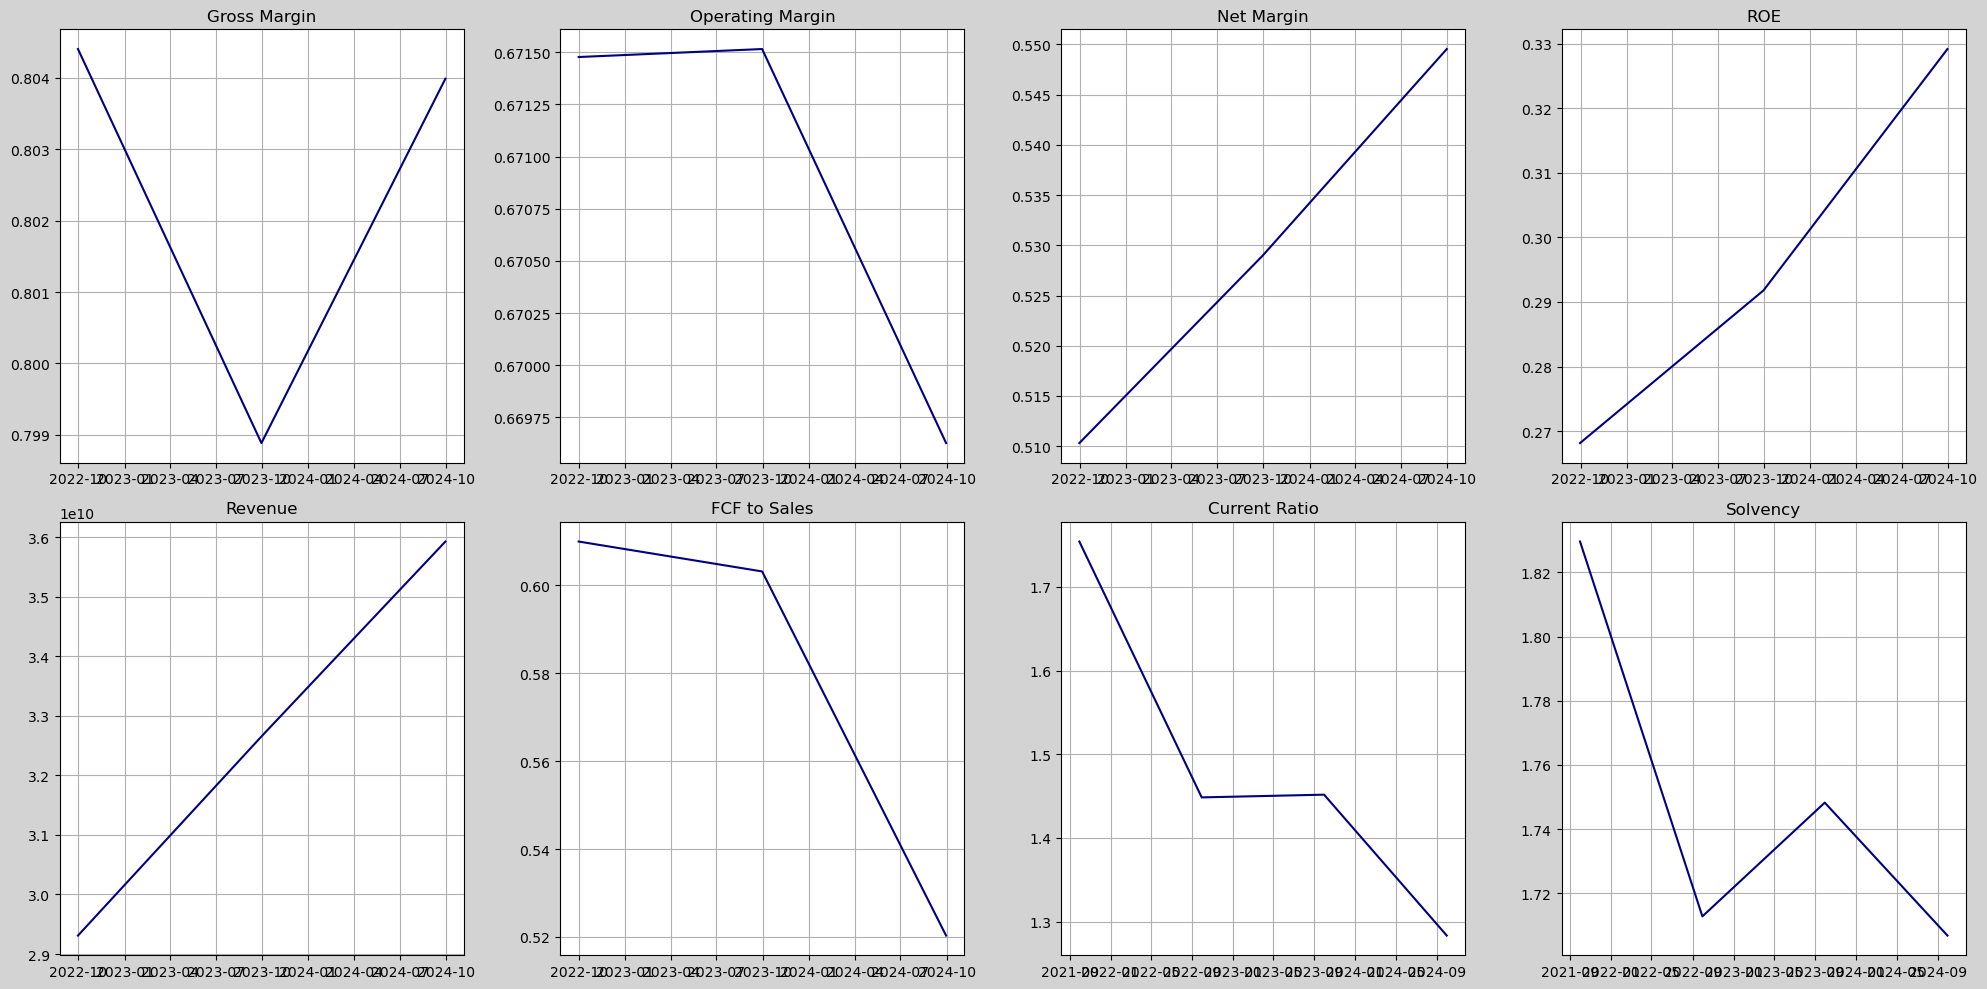

Múltiplos de PG


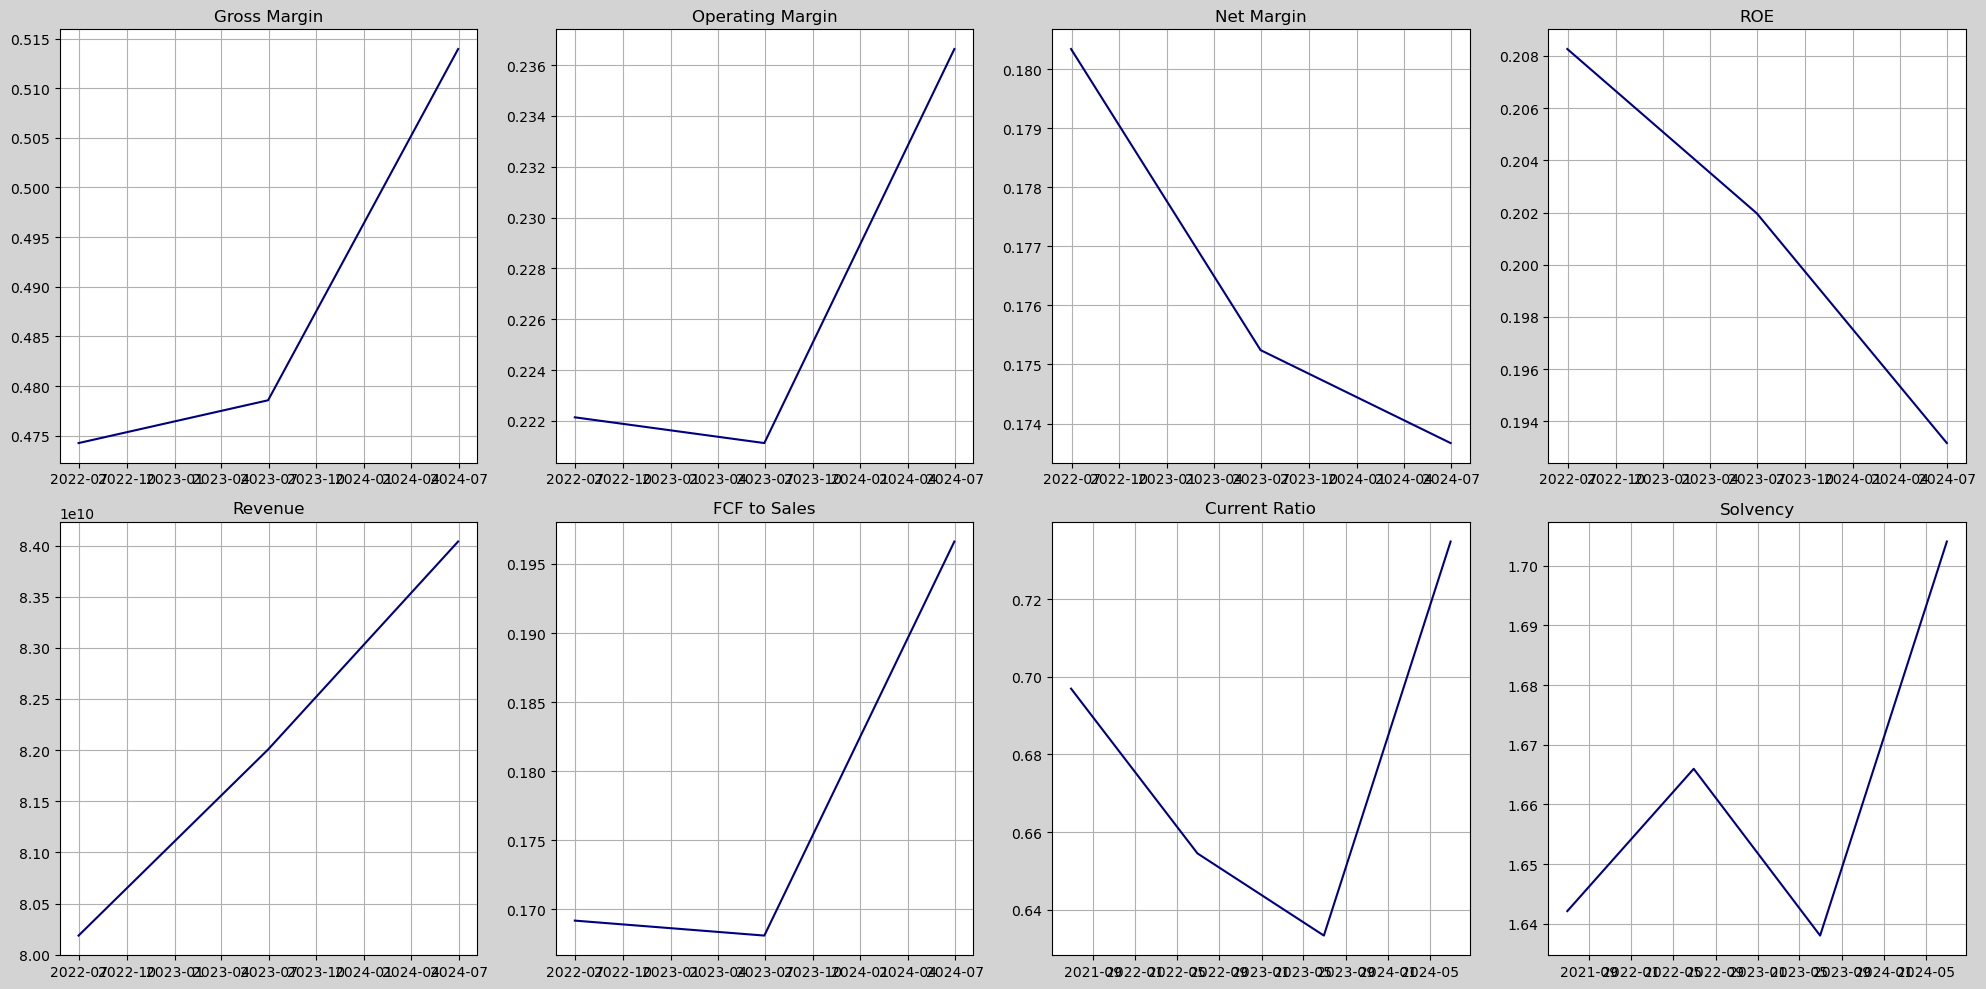

Múltiplos de MCD


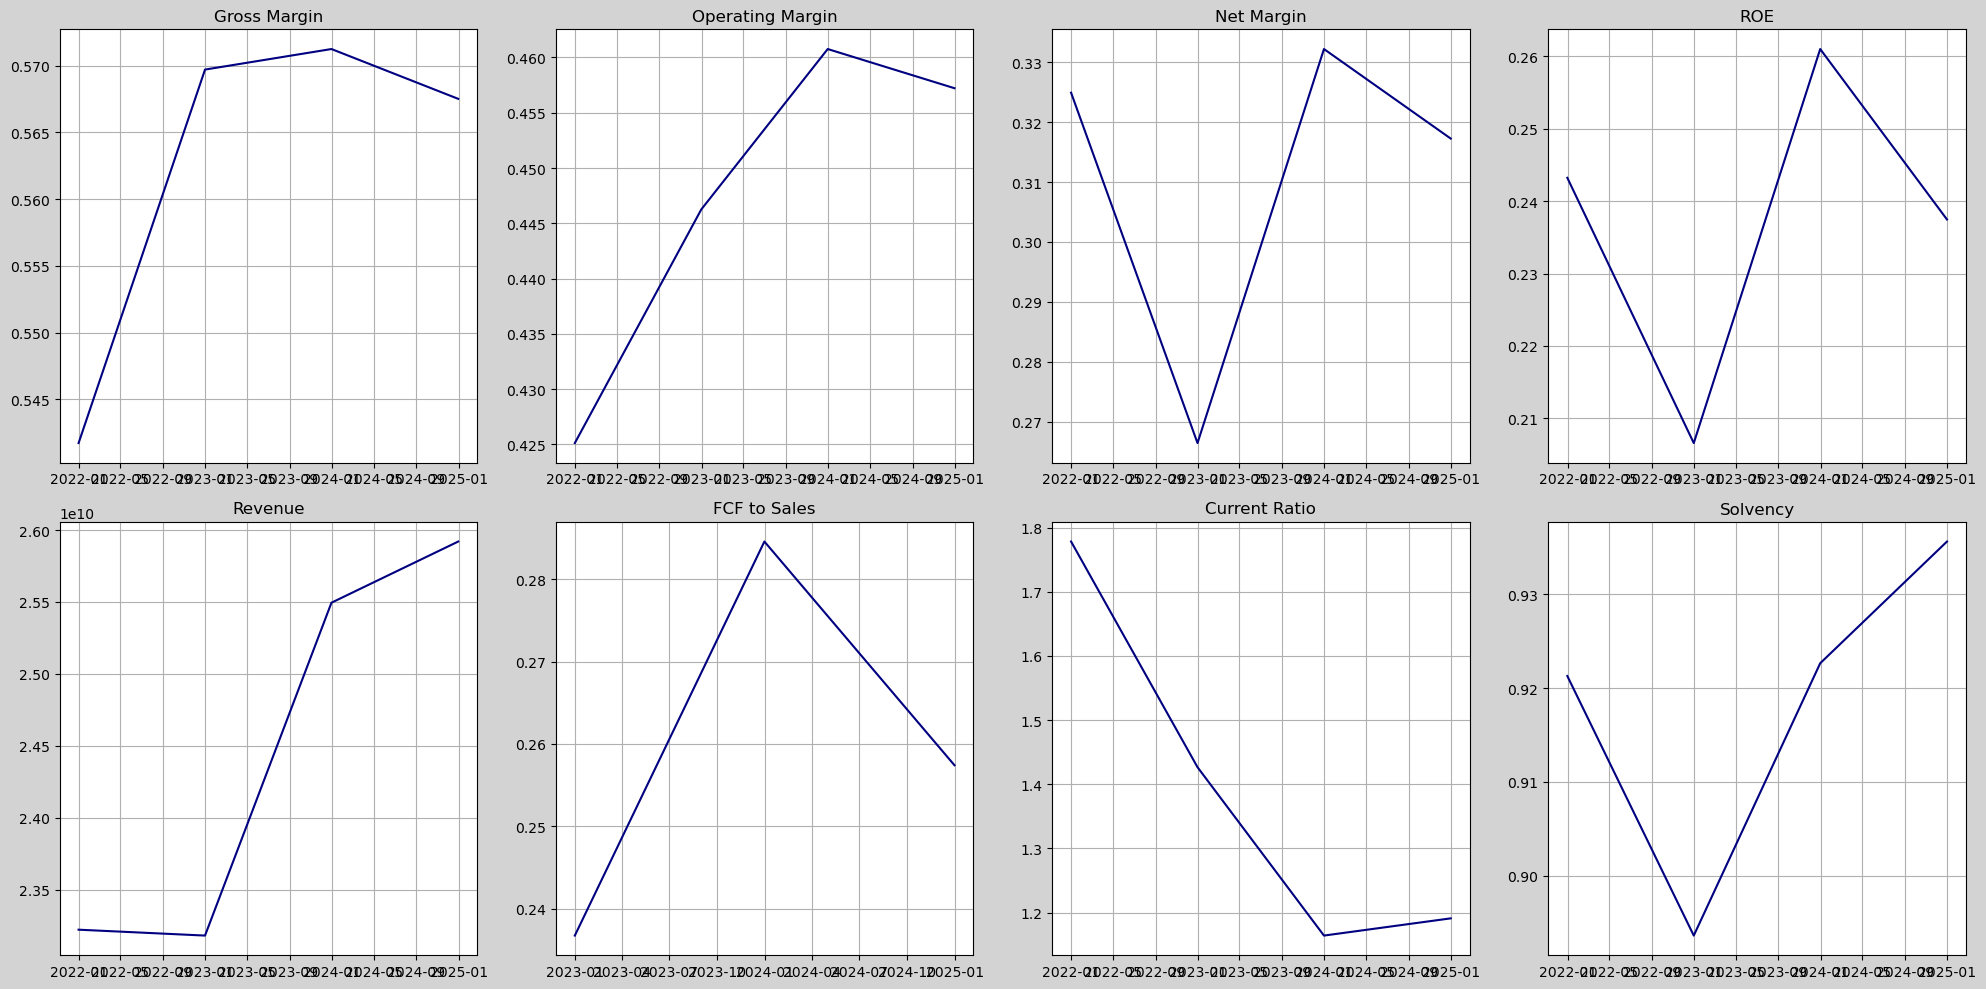

In [30]:
for ticker in tickers[0:-1]:

    bs, ist, cf = get_financials(ticker)

    gross_margin = ist.loc['Gross Profit']/ist.loc['Total Revenue']

    operating_margin = ist.loc['Operating Income']/ist.loc['Total Revenue']

    net_margin = ist.loc['Net Income Common Stockholders']/ist.loc['Total Revenue']

    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']

    revenue = ist.loc['Total Revenue']

    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']

    current_ratio = bs.loc['Current Assets']/bs.loc['Current Liabilities']

    solvency = bs.loc['Total Assets']/bs.loc['Total Liabilities Net Minority Interest']

    eps = ist.loc['Net Income Common Stockholders'] / bs.loc['Common Stock Equity']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Operating Margin': operating_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency
    })

    df_multiplos.sort_index()

    print(f'Múltiplos de {ticker}')

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.ravel()  # Aplana la matriz de ejes para indexar con un solo número

    for i, column in enumerate(df_multiplos.columns):
        axes[i].plot(df_multiplos.index, df_multiplos.iloc[:, i], c = 'navy')
        axes[i].set_title(column)
        axes[i].grid()
    plt.tight_layout()
    plt.show()

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Luis Márquez, Luis Jimenez and Diego Lozoya
</footer>